In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, Latex

import wandb
api = wandb.Api()

tqdm.pandas()

# Plotting Constants

In [2]:
# Set the font family to serif
plt.rcParams["font.family"] = "serif"

# Seaborn settings
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.color_palette("pastel")

# plotting constants
TITLE_FONT_SIZE = 18
LEGEND_FONT_SIZE = 16
WSPACE = 0.3
FIGURE_HEIGHT = 3
LINE_WIDTH = 2
FIG_SIZE = 3
MARKER_SIZE = 8
X_LABEL_ROTATION = 20

# Set colors for compositons with compression
colors = {"Wanda": "C1", "SparseGPT": "C2", "AWQ": "C3", "GPTQ": "C9"}

# Pull and Dedup Data

In [3]:
setting_columns = [
    # Overall
    "tag",
    # "seed",
    "_timestamp",

    # Interventions
    "interventions", "edit", "unlearn", "compression", "model_name",

    # Editing
    "edit_set", 
    "edit_dataset", "number_of_edits",

    # Unlearning
    "rmu_layer_id",

    # Compression
    "wbits", "compression_dataset", "sparsity_ratio",
]
evaluation_columns = [
    "qa_question_count_limit",  # An artifical max number of questions to ask during evaluation. Should be none when not debugging.
    "mmlu accuracy",            # The accuracy of the model on the MMLU dataset. This measures overall model utility. Llama-3 should be ~62%
    "wmdp_bio accuracy",        # The accuracy of the model on the WMDP bio split. This is the unlearning target. Should be ~25% when RMU is applied.
    "wmdp_cyber accuracy",      # The accuracy of the model on the WMDP cyber split. This is the unlearning target. Should be ~25% when RMU is applied.
    "PPL",                      # TODO:
    "PPL edits",                # Perplexity for the edits. Should be low when editing is applied.
    "PPl QA",                   # Perplexity for the QA. Should be low when QA is applied.
    "Generalization",           # TODO: 
    "FLOPs",                    # TODO: 
    "Success recall",           # TODO:
    "Generalization recall",    # TODO:
    "Locality",                 # TODO:
    "Average bits",             # TODO:
    "Rewrite accuracy",         # TODO:
    "PPl edits unmasked",       # TODO:
    "Local recall",             # TODO:
    "Latency",                  # TODO:
]
relevant_columns = setting_columns + evaluation_columns

In [4]:
# Composable_Interventions has all the results
project_paths = ["dri-ice/Composable_Interventions",]

filter_dict = { "state": "finished" }
data_frames = []
for project_path in project_paths:
    runs = api.runs(project_path, filters=filter_dict)

    # Iterate over eachrun and capture the c        onfig and summary metrics
    for run in tqdm(runs, desc=project_path):
        try:
            run_start_datetime = datetime.fromtimestamp(run.summary_metrics["_timestamp"])
            start_cutoff = datetime.strptime("2024-05-18 00:00:00", "%Y-%m-%d %H:%M:%S")
            end_cutoff = datetime.strptime("2024-10-29 00:00:00", "%Y-%m-%d %H:%M:%S")
            if run_start_datetime < start_cutoff or run_start_datetime > end_cutoff:
                continue

            skip_tags = ["test", "hparam_search"]
            should_skip = False
            for tag in skip_tags:
                if tag in run.config["tag"].lower():
                    should_skip = True

            if should_skip:
                continue

            config_frame = pd.DataFrame([run.config])
            summary_frame = pd.DataFrame([run.summary_metrics])
            combined_frame = pd.concat([config_frame, summary_frame], axis=1)
            data_frames.append(combined_frame)
        except Exception as e:
            print(f"Error processing run {run.id}: {e}")


dri-ice/Composable_Interventions: 100%|██████████| 8765/8765 [01:03<00:00, 138.40it/s]


In [5]:
def should_keep_frame(frame):
    if frame["edit_dataset"] == "zsre":
        return True
    
    if "edit" not in frame["interventions"]:
        return True
    
    print(f"Skipping {frame['tag']} for edit dataset {frame['edit_dataset']}")
    return False

# Sort by "tag" and "_timestamp" in descending order to have the most recent run first
all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]
all_runs_df["interventions"] = all_runs_df["interventions"].astype(str)

# Keep only the current edit dataset
all_runs_df = all_runs_df[all_runs_df.progress_apply(lambda x: should_keep_frame(x), axis=1)]

# WARNING: WHAT DOES EDIT SET 50 MEAN COMPARED TO EDIT SET 1?
# all_runs_df = all_runs_df[all_runs_df["edit_set"] == 50]
# all_runs_df_sorted = all_runs_df.sort_values(by=["tag", "_timestamp"], ascending=[True, False])
all_runs_df["date"] = pd.to_datetime(all_runs_df["_timestamp"], unit="s")
all_runs_df_sorted = all_runs_df.sort_values(by=["_timestamp"], ascending=[False])
all_runs_df_sorted["Avg WMDP"] = (all_runs_df_sorted["wmdp_bio accuracy"] + all_runs_df_sorted["wmdp_cyber accuracy"]) / 2
all_runs_df_sorted = all_runs_df_sorted[all_runs_df_sorted["qa_question_count_limit"].isnull()]

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/2553952999.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_runs_df = pd.concat(data_frames, ignore_index=True)[relevant_columns]
100%|██████████| 6726/6726 [00:00<00:00, 356508.68it/s]

Skipping lora-to-SparseGPT0.45% for edit dataset mquake
Skipping lora-to-SparseGPT0.45% for edit dataset counterfact
Skipping lora_Edit for edit dataset mquake
Skipping lora-to-SparseGPT0.25% for edit dataset mquake
Skipping lora-to-SparseGPT0.25% for edit dataset counterfact
Skipping lora-to-Wanda0.25% for edit dataset counterfact
Skipping lora-to-Wanda0.25% for edit dataset mquake
Skipping Wanda0.25%-to-lora for edit dataset counterfact
Skipping Wanda0.25%-to-lora for edit dataset mquake
Skipping lora_Edit for edit dataset counterfact
Skipping lora-to-SparseGPT0.65% for edit dataset counterfact
Skipping lora-to-SparseGPT0.65% for edit dataset mquake
Skipping lora-to-Wanda0.65% for edit dataset mquake
Skipping lora-to-Wanda0.65% for edit dataset counterfact
Skipping lora-to-AWQ2bit for edit dataset mquake
Skipping AWQ4bit-to-lora for edit dataset mquake
Skipping AWQ8bit-to-lora for edit dataset counterfact
Skipping ft_Edit for edit dataset counterfact
Skipping ft-to-Wanda0.25% for edi

In [6]:
# Sort by the recency column, for example, "date"
all_runs_df_sorted = all_runs_df_sorted.sort_values(by="date")

# Drop duplicates, keeping only the most recent occurrence for each "tag" and "edit_set"
latest_runs_df = all_runs_df_sorted.drop_duplicates(subset=["model_name", "tag", "edit_set"], keep="last")

# Define a function to calculate standard error
def standard_error(x):
    return x.std() / np.sqrt(len(x))

# Group by the "tag" column and calculate the mean for numerical columns
# grouped_df = latest_runs_df.groupby(["model_name", "tag"]).agg(["mean", standard_error])
numerical_columns = latest_runs_df.select_dtypes(include=[np.number]).columns
print(f"Numerical columns: {list(numerical_columns)}")
grouped_df = latest_runs_df.groupby(["model_name", "tag"]).agg({ col: ["mean", standard_error] for col in numerical_columns })

# Flatten the multi-level columns
grouped_df.columns = [f"{col[0]}_{col[1]}" for col in grouped_df.columns]

# Split the columns into means and standard errors
mean_columns = [col for col in grouped_df.columns if col.endswith("_mean")]
se_columns = [col for col in grouped_df.columns if col.endswith("_standard_error")]

# Create separate DataFrames for means and standard errors
mean_df = grouped_df[mean_columns].rename(columns=lambda x: x.replace("_mean", ""))
se_df = grouped_df[se_columns].rename(columns=lambda x: x.replace("_standard_error", "_se"))

# Merge the means and standard errors back into one DataFrame
all_runs_df_sorted_averaged = pd.concat([mean_df, se_df], axis=1).copy()

# Reset index if needed
all_runs_df_sorted_averaged.reset_index(inplace=True)

# Add non-numerical columns from the latest_runs_df
non_numerical_columns = latest_runs_df.select_dtypes(exclude=[np.number]).drop_duplicates(subset=["model_name", "tag"])
all_runs_df_sorted_averaged = all_runs_df_sorted_averaged.merge(non_numerical_columns, on=["model_name", "tag"], how="left")

all_runs_df_sorted_averaged["edit"] = all_runs_df_sorted_averaged["edit"].apply(lambda x: None if x == {} else x)
all_runs_df_sorted_averaged["unlearn"] = all_runs_df_sorted_averaged["unlearn"].apply(lambda x: None if x == {} else x)
all_runs_df_sorted_averaged["compression"] = all_runs_df_sorted_averaged["compression"].apply(lambda x: None if x == {} else x)

# Display the resulting DataFrame
all_runs_df_sorted_averaged

Numerical columns: ['_timestamp', 'edit_set', 'number_of_edits', 'rmu_layer_id', 'wbits', 'sparsity_ratio', 'mmlu accuracy', 'wmdp_bio accuracy', 'wmdp_cyber accuracy', 'Generalization', 'Success recall', 'Generalization recall', 'Locality', 'Average bits', 'Rewrite accuracy', 'Local recall', 'Latency', 'Avg WMDP']


,model_name,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,mmlu accuracy,wmdp_bio accuracy,...,compression,edit_dataset,compression_dataset,qa_question_count_limit,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date
0,01-ai/Yi-1.5-9B-Chat,AWQ2bit,1.727392e+09,1.0,50.0,-1.0,2.0,0.0,0.229454,0.246661,...,awq,zsre,c4,None,8100276.5,8778113,7557045,-1,6354282,2024-09-26 23:14:58.334940910
1,01-ai/Yi-1.5-9B-Chat,AWQ2bit_MEMIT,1.727429e+09,1.0,50.0,-1.0,2.0,0.0,0.229454,0.246661,...,awq,zsre,c4,None,8133088.5,8773501,7564110.5,-1,6352639.5,2024-09-27 09:23:35.068500519
2,01-ai/Yi-1.5-9B-Chat,AWQ3bit,1.727376e+09,1.0,50.0,-1.0,3.0,0.0,0.606110,0.611940,...,awq,zsre,c4,None,7.125771,306.892822,105.87944,-1,125.973007,2024-09-26 18:43:24.532109499
3,01-ai/Yi-1.5-9B-Chat,AWQ3bit_MEMIT,1.727420e+09,1.0,50.0,-1.0,3.0,0.0,0.603618,0.606441,...,awq,zsre,c4,None,7.163979,682.019836,108.887817,-1,214.402084,2024-09-27 06:52:38.689813137
4,01-ai/Yi-1.5-9B-Chat,AWQ4bit,1.727392e+09,1.0,50.0,-1.0,4.0,0.0,0.669634,0.662215,...,awq,zsre,c4,None,6.47934,356.460541,84.696404,-1,112.177864,2024-09-26 23:09:41.927449703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,mistralai/Mistral-7B-Instruct-v0.3,rmu-awq8bit,1.726225e+09,1.0,50.0,6.0,8.0,0.0,0.585743,0.306363,...,awq,zsre,c4,None,4.734568,90627.210938,300.767761,-1,448.873871,2024-09-13 10:59:33.378082514
547,mistralai/Mistral-7B-Instruct-v0.3,rmu-ft,1.726134e+09,1.0,50.0,6.0,16.0,0.0,0.494873,0.282797,...,none,zsre,c4,None,4.805961,56338.621094,857.478333,1.82 TFLOPS,1146.820679,2024-09-12 09:35:43.696657896
548,mistralai/Mistral-7B-Instruct-v0.3,rmu-lora,1.726146e+09,1.0,50.0,6.0,16.0,0.0,0.567227,0.294580,...,none,zsre,c4,None,10.45087,249094.265625,3847.212158,1.79 TFLOPS,3661.797852,2024-09-12 12:55:28.729677916
549,mistralai/Mistral-7B-Instruct-v0.3,rmu-memit,1.726228e+09,1.0,50.0,6.0,16.0,0.0,0.560675,0.293009,...,none,zsre,c4,None,4.74005,16454.134766,254.244461,1.82 TFLOPS,629.994202,2024-09-13 11:48:50.830707312


In [7]:
# The experiment tags can be inconsistent, so we need to manually map them to standard names
def set_tag(experiment_row):
    if experiment_row["interventions"] in [None, np.nan]:
        return "NONE"

    intervention_categories = None
    if isinstance(experiment_row["interventions"], str):
        intervention_categories = ast.literal_eval(experiment_row["interventions"])
    else:
        intervention_categories = experiment_row["interventions"]

    interventions = []
    for category in intervention_categories:
        category = "compression" if category == "compress" else category
        intervention = experiment_row[category].upper()
        if intervention in ["AWQ", "GPTQ"]:
            intervention += str(int(experiment_row["wbits"])) + "bit"
        if intervention in ["WANDA", "SPARSEGPT"]:
            intervention += str(int(experiment_row["sparsity_ratio"] * 100)) + "%"

        interventions.append(intervention)
    
    if len(interventions) == 0:
        interventions.append("NONE")

    return "_".join(interventions)

all_runs_df_sorted_averaged["original_tag"] = all_runs_df_sorted_averaged["tag"]
all_runs_df_sorted_averaged["tag"] = all_runs_df_sorted_averaged.progress_apply(set_tag, axis=1)
# print(all_runs_df_sorted_averaged[all_runs_df_sorted_averaged["model_name"] == "mistralai/Mistral-7B-Instruct-v0.3"].value_counts(["tag", "model_name"]).sort_index())
all_runs_df_sorted_averaged[["tag", "model_name"]]
# all_runs_df_sorted_averaged[["model_name_x" ,"model_name_y"]]

100%|██████████| 551/551 [00:00<00:00, 81752.50it/s]


,tag,model_name
0,AWQ2bit,01-ai/Yi-1.5-9B-Chat
1,AWQ2bit_MEMIT,01-ai/Yi-1.5-9B-Chat
2,AWQ3bit,01-ai/Yi-1.5-9B-Chat
3,AWQ3bit_MEMIT,01-ai/Yi-1.5-9B-Chat
4,AWQ4bit,01-ai/Yi-1.5-9B-Chat
...,...,...
546,RMU_AWQ8bit,mistralai/Mistral-7B-Instruct-v0.3
547,RMU_FT,mistralai/Mistral-7B-Instruct-v0.3
548,RMU_LORA,mistralai/Mistral-7B-Instruct-v0.3
549,RMU_MEMIT,mistralai/Mistral-7B-Instruct-v0.3


In [8]:
# Drop duplicates, keeping only the first occurrence (which is the most recent due to sorting)
# all_runs_df_deduplicated = all_runs_df_sorted.drop_duplicates(subset=[col for col in setting_columns if col not in ["_timestamp", "tag", "date"]], keep="first")
all_runs_df_deduplicated = all_runs_df_sorted_averaged.drop_duplicates(subset=["model_name", "tag"], keep="first")
all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))

rename_dict = {
    "meta-llama/Meta-Llama-3-8B" : "Llama-3 (8b)",
    "mistralai/Mistral-7B-Instruct-v0.3": "Mistral (7b)",
    "01-ai/Yi-1.5-9B-Chat": "Yi 1.5 (9b)",
    "microsoft/Phi-3-mini-4k-instruct": "Phi-3 (3.8b)",
    "ft" : "Fine-tune",
    "memit" : "MEMIT",
    "lora" : "LoRA",
    "wanda" : "Wanda",
    "sparsegpt" : "SparseGPT",
    "gptq" : "GPTQ",
    "awq" : "AWQ",
    "rmu" : "RMU",
    "ga": "GA",
    "gd": "GD",
}
all_runs_df_deduplicated["model_name"] = all_runs_df_deduplicated["model_name"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated["edit"] = all_runs_df_deduplicated["edit"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated["compression"] = all_runs_df_deduplicated["compression"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated["unlearn"] = all_runs_df_deduplicated["unlearn"].apply(lambda x : rename_dict.get(x, None))
all_runs_df_deduplicated = all_runs_df_deduplicated
display(all_runs_df_deduplicated.value_counts(["model_name", "tag"]).sort_index())
print(f"Number of experiments: {len(all_runs_df_deduplicated)}")
print(f"Experiments by Model: {all_runs_df_deduplicated['model_name'].value_counts()}")

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/3718562974.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runs_df_deduplicated["interventions"] = all_runs_df_deduplicated["interventions"].apply(lambda x : ast.literal_eval(x))
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/3718562974.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_runs_df_deduplicated["model_name"] = all_runs_df_deduplicated["model_name"].apply(lambda x : rename_dict.get(x, None))
/var/fol

model_name    tag           
Llama-3 (8b)  AWQ2bit           1
              AWQ2bit_FT        1
              AWQ2bit_GA        1
              AWQ2bit_GD        1
              AWQ2bit_LORA      1
                               ..
Yi 1.5 (9b)   WANDA55%_MEMIT    1
              WANDA65%          1
              WANDA65%_MEMIT    1
              WANDA75%          1
              WANDA75%_MEMIT    1
Name: count, Length: 549, dtype: int64

Number of experiments: 549
Experiments by Model: model_name
Llama-3 (8b)    311
Phi-3 (3.8b)    123
Mistral (7b)     78
Yi 1.5 (9b)      37
Name: count, dtype: int64


# Check for Missing Ablation Experments

## Mistral Ablation

In [9]:
unlearning_interventions = ["rmu"]
editing_interventions = ["memit"]
pruning_interventions = ["wanda"]
pruning_levels = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
quant_interventions = ["awq"]
quant_levels = [2, 3, 4, 5, 6, 8]
experiment_combinations = []

# Unlearning and Editing
for unlearner in unlearning_interventions:
    for editor in editing_interventions:
        experiment_combinations.append({
            "interventions": ["unlearn", "edit"], "edit": editor, "unlearn": unlearner, "wbits": None, "sparsity_ratio": None, })
        experiment_combinations.append({
            "interventions": ["edit", "unlearn"], "edit": editor, "unlearn": unlearner, "wbits": None, "sparsity_ratio": None, })

# Unlearning and compression
for unlearner in unlearning_interventions:
    for pruner in pruning_interventions:
        for pruning_level in pruning_levels:
            experiment_combinations.append({
                "interventions": ["unlearn", "compression"], "edit": None, "unlearn": unlearner, "compression": pruner, "sparsity_ratio": pruning_level, })
            experiment_combinations.append({
                "interventions": ["compression", "unlearn"], "edit": None, "unlearn": unlearner, "compression": pruner, "sparsity_ratio": pruning_level, })

    for quantizer in quant_interventions:
        for quant_level in quant_levels:
            experiment_combinations.append({
                "interventions": ["unlearn", "compression"], "edit": None, "unlearn": unlearner, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })
            experiment_combinations.append({
                "interventions": ["compression", "unlearn"], "edit": None, "unlearn": unlearner, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })

# Editing and compression
for editor in editing_interventions:
    for pruner in pruning_interventions:
        for pruning_level in pruning_levels:
            experiment_combinations.append({
                "interventions": ["edit", "compression"], "edit": editor, "unlearn": None, "compression": pruner, "sparsity_ratio": pruning_level, })
            experiment_combinations.append({
                "interventions": ["compression", "edit"], "edit": editor, "unlearn": None, "compression": pruner, "sparsity_ratio": pruning_level, })

    for quantizer in quant_interventions:
        for quant_level in quant_levels:
            experiment_combinations.append({
                "interventions": ["edit", "compression"], "edit": editor, "unlearn": None, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })
            experiment_combinations.append({
                "interventions": ["compression", "edit"], "edit": editor, "unlearn": None, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })

# No interventions
experiment_combinations.append({
    "interventions": [], "edit": None, "unlearn": None, "compression": None, "wbits": None, "sparsity_ratio": None })

# Just edit
for editor in editing_interventions:
    experiment_combinations.append({
        "interventions": ["edit"], "edit": editor, "unlearn": None, "compression": None, "wbits": None, "sparsity_ratio": None })

# Just unlearn
for unlearner in unlearning_interventions:
    experiment_combinations.append({
        "interventions": ["unlearn"], "edit": None, "unlearn": unlearner, "compression": None, "wbits": None, "sparsity_ratio": None })

# Just pruning
for pruner in pruning_interventions:
    for pruning_level in pruning_levels:
        experiment_combinations.append({
            "interventions": ["compression"], "edit": None, "unlearn": None, "compression": pruner, "sparsity_ratio": pruning_level, })

# Just quantization
for quantizer in quant_interventions:
    for quant_level in quant_levels:
        experiment_combinations.append({
            "interventions": ["compression"], "edit": None, "unlearn": None, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })

print(f"Total experiment combinations for Mistral ablation: {len(experiment_combinations)}")
model_name = "Mistral (7b)"
mistral_tags = set(all_runs_df_deduplicated[all_runs_df_deduplicated["model_name"] == model_name]["tag"].unique())
experiment_statuses = []
for experiment in experiment_combinations:
    experiment_tag = set_tag(experiment)
    experiment_statuses.append({
        "experiment_tag": experiment_tag,
        "first_intervention": experiment_tag.split("_")[0],
        "second_intervention": experiment_tag.split("_")[1] if len(experiment_tag.split("_")) > 1 else None,
        "completed": experiment_tag in mistral_tags,
    })

experiment_statuses_df = pd.DataFrame(experiment_statuses)
experiment_statuses_df.to_csv("mistral_experiment_statuses.csv", index=False)

# Percent of experiments completed
print(f"Percent of experiments completed: {experiment_statuses_df['completed'].mean() * 100:.2f}%")

# Missing experiments
missing_experiments = experiment_statuses_df[experiment_statuses_df["completed"] == False].sort_values(by="experiment_tag")
display(missing_experiments)
assert len(missing_experiments) == 0, "There are missing experiments"

Total experiment combinations for Mistral ablation: 65
Percent of experiments completed: 100.00%


,experiment_tag,first_intervention,second_intervention,completed


## Yi Ablation

In [10]:
unlearning_interventions = []
editing_interventions = ["memit"]
pruning_interventions = ["wanda"]
pruning_levels = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
quant_interventions = ["awq"]
quant_levels = [2, 3, 4, 5, 6, 8]
experiment_combinations = []

# Unlearning and Editing
for unlearner in unlearning_interventions:
    for editor in editing_interventions:
        experiment_combinations.append({
            "interventions": ["unlearn", "edit"], "edit": editor, "unlearn": unlearner, "wbits": None, "sparsity_ratio": None, })
        experiment_combinations.append({
            "interventions": ["edit", "unlearn"], "edit": editor, "unlearn": unlearner, "wbits": None, "sparsity_ratio": None, })

# Unlearning and compression
for unlearner in unlearning_interventions:
    for pruner in pruning_interventions:
        for pruning_level in pruning_levels:
            experiment_combinations.append({
                "interventions": ["unlearn", "compression"], "edit": None, "unlearn": unlearner, "compression": pruner, "sparsity_ratio": pruning_level, })
            experiment_combinations.append({
                "interventions": ["compression", "unlearn"], "edit": None, "unlearn": unlearner, "compression": pruner, "sparsity_ratio": pruning_level, })

    for quantizer in quant_interventions:
        for quant_level in quant_levels:
            experiment_combinations.append({
                "interventions": ["unlearn", "compression"], "edit": None, "unlearn": unlearner, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })
            experiment_combinations.append({
                "interventions": ["compression", "unlearn"], "edit": None, "unlearn": unlearner, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })

# Editing and compression
for editor in editing_interventions:
    for pruner in pruning_interventions:
        for pruning_level in pruning_levels:
            experiment_combinations.append({
                "interventions": ["edit", "compression"], "edit": editor, "unlearn": None, "compression": pruner, "sparsity_ratio": pruning_level, })
            experiment_combinations.append({
                "interventions": ["compression", "edit"], "edit": editor, "unlearn": None, "compression": pruner, "sparsity_ratio": pruning_level, })

    for quantizer in quant_interventions:
        for quant_level in quant_levels:
            experiment_combinations.append({
                "interventions": ["edit", "compression"], "edit": editor, "unlearn": None, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })
            experiment_combinations.append({
                "interventions": ["compression", "edit"], "edit": editor, "unlearn": None, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })

# No interventions
experiment_combinations.append({
    "interventions": [], "edit": None, "unlearn": None, "compression": None, "wbits": None, "sparsity_ratio": None })

# Just edit
for editor in editing_interventions:
    experiment_combinations.append({
        "interventions": ["edit"], "edit": editor, "unlearn": None, "compression": None, "wbits": None, "sparsity_ratio": None })

# Just unlearn
for unlearner in unlearning_interventions:
    experiment_combinations.append({
        "interventions": ["unlearn"], "edit": None, "unlearn": unlearner, "compression": None, "wbits": None, "sparsity_ratio": None })

# Just pruning
for pruner in pruning_interventions:
    for pruning_level in pruning_levels:
        experiment_combinations.append({
            "interventions": ["compression"], "edit": None, "unlearn": None, "compression": pruner, "sparsity_ratio": pruning_level, })

# Just quantization
for quantizer in quant_interventions:
    for quant_level in quant_levels:
        experiment_combinations.append({
            "interventions": ["compression"], "edit": None, "unlearn": None, "compression": quantizer, "wbits": quant_level, "sparsity_ratio": None, })

print(f"Total experiment combinations for Yi ablation: {len(experiment_combinations)}")
yi_tags = set(all_runs_df_deduplicated[all_runs_df_deduplicated["model_name"] == "Yi 1.5 (9b)"]["tag"].unique())
experiment_statuses = []
for experiment in experiment_combinations:
    experiment_tag = set_tag(experiment)
    experiment_statuses.append({
        "experiment_tag": experiment_tag,
        "first_intervention": experiment_tag.split("_")[0],
        "second_intervention": experiment_tag.split("_")[1] if len(experiment_tag.split("_")) > 1 else None,
        "completed": experiment_tag in yi_tags,
    })

experiment_statuses_df = pd.DataFrame(experiment_statuses)
experiment_statuses_df.to_csv("mistral_experiment_statuses.csv", index=False)

# Percent of experiments completed
print(f"Percent of experiments completed: {experiment_statuses_df['completed'].mean() * 100:.2f}%")

# Missing experiments
missing_experiments = experiment_statuses_df[experiment_statuses_df["completed"] == False].sort_values(by="experiment_tag")
display(missing_experiments)
# assert len(missing_experiments) == 0, "There are missing experiments"

Total experiment combinations for Yi ablation: 38
Percent of experiments completed: 97.37%


,experiment_tag,first_intervention,second_intervention,completed
25,MEMIT,MEMIT,None,False


## Check Main Results Experiment Status

In [11]:
# Math for determining number of interventions
awq_settings = 6
gptq_settings = 4 # only support quantize to [2, 3, 4, 8] bits.
wanda_count = 6
sparsegpt_count = 6
editor_settings = 3
composition_factor = 2

editor_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + 1) * editor_settings
print(editor_count // 2)

rmu_count = composition_factor * (awq_settings + gptq_settings + wanda_count + sparsegpt_count + editor_settings)
print(rmu_count)

69
50


In [12]:
all_runs_df_deduplicated["unlearn"].value_counts()

unlearn
RMU    82
GD     54
GA     51
Name: count, dtype: int64

In [13]:
NUM_UNLEARNING = 3
NUM_EDITING = 3
NUM_COMPRESSION = 4 + 6 + 6 + 6
combination_of_unlearning = 2 * NUM_UNLEARNING * NUM_COMPRESSION
combination_of_unlearning

132

In [14]:

main_results = all_runs_df_deduplicated[all_runs_df_deduplicated["model_name"] == "Llama-3 (8b)"]

categories = {
    "No Intervention": main_results[main_results["interventions"].apply(lambda x: x == [])].copy(),
    "Editing": main_results[main_results["interventions"].apply(lambda x: x == ["edit"])].copy(),
    "Compression": main_results[main_results["interventions"].apply(lambda x: x == ["compress"])].copy(),
    "Edit to Compression": main_results[main_results["interventions"].apply(lambda x: x == ["edit", "compress"])].copy(),
    "Compression to Edit": main_results[main_results["interventions"].apply(lambda x: x == ["compress", "edit"])].copy(),
    "Unlearn": main_results[main_results["interventions"].apply(lambda x: x == ["unlearn"])].copy(),
    "Edit to Unlearn": main_results[main_results["interventions"].apply(lambda x: x == ["edit", "unlearn"])].copy(),
    "Unlearn to Edit": main_results[main_results["interventions"].apply(lambda x: x == ["unlearn", "edit"])].copy(),
    "Compress to Unlearn": main_results[main_results["interventions"].apply(lambda x: x == ["compress", "unlearn"])].copy(),
    "Unlearn to Compress": main_results[main_results["interventions"].apply(lambda x: x == ["unlearn", "compress"])].copy()
}

assert len(categories["No Intervention"]) == 1, f"{len(categories['No Intervention'])} != 1"
assert len(categories["Editing"]) == 3, f"{len(categories['Editing'])} != 3"

# display(categories["Compression"])
assert len(categories["Compression"]) == (awq_settings + gptq_settings + wanda_count + sparsegpt_count), f"{len(categories['Compression'])} != {awq_settings + gptq_settings + wanda_count + sparsegpt_count}"

# assert len(categories["Edit to Compression"]) == editor_count // 2, f"{len(categories['Edit to Compression'])} != {editor_count // 2}"

assert len(categories["Compression to Edit"]) == (editor_count // 2 ) - 3, f"{len(categories['Compression to Edit'])} != {editor_count // 2}" # TODO: Fix this by getting the latest results
assert len(categories["Unlearn"]) == 3, f"{len(categories['Unlearn'])} != 3"
assert len(categories["Edit to Unlearn"]) == 9, f"{len(categories['Edit to Unlearn'])} != 9"
assert len(categories["Unlearn to Edit"]) == 9, f"{len(categories['Unlearn to Edit'])} != 9"

display(categories["Compress to Unlearn"])
assert len(categories["Compress to Unlearn"]) == combination_of_unlearning // 2, f"{len(categories['Compress to Unlearn'])} != {combination_of_unlearning // 2}"

display(categories["Unlearn to Compress"])
assert len(categories["Unlearn to Compress"]) == combination_of_unlearning // 2, f"{len(categories['Unlearn to Compress'])} != {rmucombination_of_unlearning_count // 2}"

,model_name,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,mmlu accuracy,wmdp_bio accuracy,...,edit_dataset,compression_dataset,qa_question_count_limit,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date,original_tag
126,Llama-3 (8b),AWQ2bit_GA,1.718194e+09,1.000000,50.0,-1.000000,2.0,0.00,0.268908,0.240377,...,zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 12:02:27.059515953,awq2bit-ga
127,Llama-3 (8b),AWQ2bit_GD,1.718204e+09,1.000000,50.0,-1.000000,2.0,0.00,0.268908,0.240377,...,zsre,c4,None,4496028624899119061335958001549312.0,2617349.75,6866961.5,-1,5905774.5,2024-06-12 14:48:16.610423088,awq2bit-gd
128,Llama-3 (8b),AWQ2bit_RMU,1.717570e+09,9.545455,50.0,3.181818,2.0,0.00,0.268908,0.240377,...,zsre,c4,None,1749321.75,1055937.75,999726.5,-1,915356.5,2024-05-20 19:19:14.861625671,awq2bit-rmu
129,Llama-3 (8b),AWQ3bit_GA,1.718194e+09,1.000000,50.0,-1.000000,3.0,0.00,0.272896,0.241948,...,zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 12:03:07.964953661,awq3bit-ga
130,Llama-3 (8b),AWQ3bit_GD,1.718204e+09,1.000000,50.0,-1.000000,3.0,0.00,0.341832,0.245876,...,zsre,c4,None,166895.90625,83131.453125,20670.785156,-1,3257.42627,2024-06-12 14:47:07.710373163,awq3bit-gd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Llama-3 (8b),WANDA65%_GD,1.718204e+09,1.000000,50.0,-1.000000,4.0,0.65,0.229098,0.249018,...,zsre,c4,None,16268.005859,5423145.5,81961160,447.25 GFLOPS,89329664,2024-06-12 14:53:38.419730186,wanda0.65\%-gd
344,Llama-3 (8b),WANDA65%_RMU,1.716764e+09,18.666667,50.0,3.666667,4.0,0.65,0.229360,0.249542,...,zsre,c4,None,45.534767,83373.453125,1477.523804,760 GFLOPS,1549.510742,2024-05-20 19:27:06.522696495,wanda0.65\%-rmu
345,Llama-3 (8b),WANDA75%_GA,1.718194e+09,1.000000,50.0,-1.000000,4.0,0.75,0.229811,0.249018,...,zsre,c4,None,8125971838094910145582358934348365824.0,176520989218511062933962752.0,31936578699555629957120.0,357.84 GFLOPS,31529243875858664390656.0,2024-06-12 12:09:17.554701090,wanda0.75\%-ga
346,Llama-3 (8b),WANDA75%_GD,1.718204e+09,1.000000,50.0,-1.000000,4.0,0.75,0.246902,0.247447,...,zsre,c4,None,10226426,743558.8125,145133.09375,357.84 GFLOPS,128967.648438,2024-06-12 14:55:21.376342773,wanda0.75\%-gd


,model_name,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,mmlu accuracy,wmdp_bio accuracy,...,edit_dataset,compression_dataset,qa_question_count_limit,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date,original_tag
170,Llama-3 (8b),GA_AWQ2bit,1.718191e+09,1.000000,50.0,-1.000000,2.0,0.00,0.246546,0.247447,...,zsre,c4,None,1769133.875,1243236.75,1118986.25,-1,1245522.5,2024-06-12 11:13:37.028556824,ga-awq2bit
171,Llama-3 (8b),GA_AWQ3bit,1.718191e+09,1.000000,50.0,-1.000000,3.0,0.00,0.441675,0.492537,...,zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 11:17:15.184798717,ga-awq3bit
172,Llama-3 (8b),GA_AWQ4bit,1.718191e+09,1.000000,50.0,-1.000000,4.0,0.00,0.465318,0.524745,...,zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 11:20:13.570003510,ga-awq4bit
173,Llama-3 (8b),GA_AWQ5bit,1.718191e+09,1.000000,50.0,-1.000000,5.0,0.00,0.498576,0.556952,...,zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 11:20:19.390620708,ga-awq5bit
174,Llama-3 (8b),GA_AWQ6bit,1.718191e+09,1.000000,50.0,-1.000000,6.0,0.00,0.489389,0.559309,...,zsre,c4,None,Infinity,Infinity,Infinity,-1,Infinity,2024-06-12 11:21:07.118664503,ga-awq6bit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,Llama-3 (8b),RMU_WANDA35%,1.717690e+09,5.500000,50.0,3.000000,4.0,0.35,0.532602,0.258759,...,zsre,c4,None,6.360727,58684.835938,459.011627,1.3 TFLOPS,647.534851,2024-06-06 13:50:28.648183107,rmu-wanda0.35\%
308,Llama-3 (8b),RMU_WANDA45%,1.717546e+09,10.000000,50.0,3.200000,4.0,0.45,0.478009,0.272270,...,zsre,c4,None,7.707963,25395.089844,538.735168,1.12 TFLOPS,620.10907,2024-05-20 19:02:13.503230572,rmu-wanda0.45\%
309,Llama-3 (8b),RMU_WANDA55%,1.717684e+09,5.500000,50.0,3.000000,4.0,0.55,0.350570,0.259309,...,zsre,c4,None,13.729619,46809.050781,728.273926,938.82 GFLOPS,732.329468,2024-06-06 14:15:58.615832090,rmu-wanda0.55\%
310,Llama-3 (8b),RMU_WANDA65%,1.717552e+09,9.545455,50.0,3.181818,4.0,0.65,0.229500,0.242020,...,zsre,c4,None,52.669495,78055.304688,1446.553223,760 GFLOPS,1535.829468,2024-05-20 19:06:01.385294199,rmu-wanda0.65\%


In [15]:
# Define intervention names and types
intervention_names = [intervention for intervention in list(main_results["edit"].unique()) + list(main_results["unlearn"].unique()) + list(main_results["compression"].unique()) if intervention is not None]
intervention_type = {
    "LoRA": "edit",
    "MEMIT": "edit",
    "Fine-tune": "edit",
    "SparseGPT": "compression",
    "Wanda": "compression",
    "GPTQ": "compression",
    "AWQ": "compression",
    "RMU": "unlearn",
    "GA": "unlearn",
    "GD": "unlearn",
}

# Initialize heatmap data frames with default values
default_value = None
mmlu_oi_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_oi_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
edit_oi_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
generalization_oi_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
locality_oi_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

# Initialize max value data frames
mmlu_mce_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
wmdp_mce_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
edit_mce_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
generalization_mce_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
locality_mce_main_results = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

# Populate the heatmap and max value data frames
for first_intervention in intervention_names:
    for second_intervention in intervention_names:
        first_intervention_type = intervention_type[first_intervention]
        second_intervention_type = intervention_type[second_intervention]
        if first_intervention_type == second_intervention_type:
            continue

        compositions = main_results[(main_results[first_intervention_type] == first_intervention) & (main_results[second_intervention_type] == second_intervention)]
        if first_intervention in ["SparseGPT", "Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
            compositions = compositions[compositions["sparsity_ratio"] == 0.25]
        elif first_intervention in ["GPTQ", "AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
            compositions = compositions[compositions["wbits"] == 4]
        
        assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
        
        # Calculate OIs
        mmlu_diff = abs(compositions["mmlu accuracy"].iloc[0] - compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_oi_main_results[first_intervention][second_intervention] = mmlu_diff
        
        avg_wmdp_diff = abs(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2) - ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
        wmdp_oi_main_results[first_intervention][second_intervention] = avg_wmdp_diff
        
        edit_diff = abs(compositions["Rewrite accuracy"].iloc[0] - compositions["Rewrite accuracy"].iloc[1]).round(4)
        edit_oi_main_results[first_intervention][second_intervention] = edit_diff

        generalization_diff = abs(compositions["Generalization"].iloc[0] - compositions["Generalization"].iloc[1]).round(4)
        generalization_oi_main_results[first_intervention][second_intervention] = generalization_diff

        locality_diff = abs(compositions["Locality"].iloc[0] - compositions["Locality"].iloc[1]).round(4)
        locality_oi_main_results[first_intervention][second_intervention] = locality_diff
        
        # Calculate MCE values
        mmlu_mce = 1 - max(compositions["mmlu accuracy"].iloc[0], compositions["mmlu accuracy"].iloc[1]).round(4)
        mmlu_mce_main_results[first_intervention][second_intervention] = mmlu_mce
        
        avg_wmdp_acc = min((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2, (compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2).round(4)
        wmdp_mce_main_results[first_intervention][second_intervention] = avg_wmdp_acc
        
        edit_mce = 1 - max(compositions["Rewrite accuracy"].iloc[0], compositions["Rewrite accuracy"].iloc[1]).round(4)
        edit_mce_main_results[first_intervention][second_intervention] = edit_mce

        generalization_mce = 1 - max(compositions["Generalization"].iloc[0], compositions["Generalization"].iloc[1]).round(4)
        generalization_mce_main_results[first_intervention][second_intervention] = generalization_mce

        locality_mce = 1 - max(compositions["Locality"].iloc[0], compositions["Locality"].iloc[1]).round(4)
        locality_mce_main_results[first_intervention][second_intervention] = locality_mce

# Display the results
print("MMLU OI")
display(mmlu_oi_main_results)

print("MMLU MCE Values")
display(mmlu_mce_main_results)

print("WMDP OI")
display(wmdp_oi_main_results)

print("WMDP MCE Values")
display(wmdp_mce_main_results)

print("Rewrite OI")
display(edit_oi_main_results)

print("Rewrite MCE Values")
display(edit_mce_main_results)

print("Generalization OI")
display(generalization_oi_main_results)

print("Generalization MCE Values")
display(generalization_mce_main_results)

print("Locality OI")
display(locality_oi_main_results)

print("Locality MCE Values")
display(locality_mce_main_results)

MMLU OI


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/1125816209.py:49: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mmlu_oi_main_results[first_intervention][second_intervention] = mmlu_diff
/var/folders/_m/m_v8tmqs05lf3_0frmhh2t

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0071,0.1820,0.0122,0.0174,0.0032,0.0037,0.0053
LoRA,NaN,NaN,NaN,0.0706,0.1414,0.0390,0.0023,0.0120,0.0001,0.0009
MEMIT,NaN,NaN,NaN,0.0409,0.2225,0.0025,0.0084,0.0139,0.0040,0.0034
GA,0.0071,0.0706,0.0409,NaN,NaN,NaN,0.0174,0.0921,0.0580,0.0234
GD,0.1820,0.1414,0.2225,NaN,NaN,NaN,0.0700,0.2398,0.0927,0.0100
RMU,0.0122,0.0390,0.0025,NaN,NaN,NaN,0.0085,0.0500,0.0080,0.0148
AWQ,0.0174,0.0023,0.0084,0.0174,0.0700,0.0085,NaN,NaN,NaN,NaN
GPTQ,0.0032,0.0120,0.0139,0.0921,0.2398,0.0500,NaN,NaN,NaN,NaN
SparseGPT,0.0037,0.0001,0.0040,0.0580,0.0927,0.0080,NaN,NaN,NaN,NaN
Wanda,0.0053,0.0009,0.0034,0.0234,0.0100,0.0148,NaN,NaN,NaN,NaN


MMLU MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.4745,0.4100,0.4305,0.4094,0.4138,0.3978,0.3976
LoRA,NaN,NaN,NaN,0.6435,0.4130,0.4443,0.4144,0.4189,0.4039,0.4036
MEMIT,NaN,NaN,NaN,0.5074,0.4207,0.4381,0.4142,0.4109,0.4037,0.4044
GA,0.4745,0.6435,0.5074,NaN,NaN,NaN,0.5347,0.5246,0.4917,0.4591
GD,0.4100,0.4130,0.4207,NaN,NaN,NaN,0.5803,0.4358,0.4227,0.4200
RMU,0.4305,0.4443,0.4381,NaN,NaN,NaN,0.4383,0.4205,0.4341,0.4288
AWQ,0.4094,0.4144,0.4142,0.5347,0.5803,0.4383,NaN,NaN,NaN,NaN
GPTQ,0.4138,0.4189,0.4109,0.5246,0.4358,0.4205,NaN,NaN,NaN,NaN
SparseGPT,0.3978,0.4039,0.4037,0.4917,0.4227,0.4341,NaN,NaN,NaN,NaN
Wanda,0.3976,0.4036,0.4044,0.4591,0.4200,0.4288,NaN,NaN,NaN,NaN


WMDP OI


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0046,0.0001,0.0450,0.0144,0.0090,0.0026,0.0039
LoRA,NaN,NaN,NaN,0.0661,0.2437,0.0022,0.0006,0.0097,0.0019,0.0008
MEMIT,NaN,NaN,NaN,0.0508,0.0205,0.0086,0.0023,0.0050,0.0016,0.0014
GA,0.0046,0.0661,0.0508,NaN,NaN,NaN,0.0232,0.0880,0.0300,0.0285
GD,0.0001,0.2437,0.0205,NaN,NaN,NaN,0.0012,0.0230,0.2218,0.1733
RMU,0.0450,0.0022,0.0086,NaN,NaN,NaN,0.0150,0.1801,0.0241,0.0332
AWQ,0.0144,0.0006,0.0023,0.0232,0.0012,0.0150,NaN,NaN,NaN,NaN
GPTQ,0.0090,0.0097,0.0050,0.0880,0.0230,0.1801,NaN,NaN,NaN,NaN
SparseGPT,0.0026,0.0019,0.0016,0.0300,0.2218,0.0241,NaN,NaN,NaN,NaN
Wanda,0.0039,0.0008,0.0014,0.0285,0.1733,0.0332,NaN,NaN,NaN,NaN


WMDP MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.4664,0.2937,0.2751,0.5341,0.5423,0.5525,0.5586
LoRA,NaN,NaN,NaN,0.2762,0.2993,0.2947,0.5472,0.5341,0.5434,0.5469
MEMIT,NaN,NaN,NaN,0.3966,0.2557,0.2928,0.5516,0.5477,0.5570,0.5573
GA,0.4664,0.2762,0.3966,NaN,NaN,NaN,0.4257,0.3443,0.4318,0.4586
GD,0.2937,0.2993,0.2557,NaN,NaN,NaN,0.2434,0.2438,0.2750,0.3475
RMU,0.2751,0.2947,0.2928,NaN,NaN,NaN,0.2733,0.2667,0.2850,0.2854
AWQ,0.5341,0.5472,0.5516,0.4257,0.2434,0.2733,NaN,NaN,NaN,NaN
GPTQ,0.5423,0.5341,0.5477,0.3443,0.2438,0.2667,NaN,NaN,NaN,NaN
SparseGPT,0.5525,0.5434,0.5570,0.4318,0.2750,0.2850,NaN,NaN,NaN,NaN
Wanda,0.5586,0.5469,0.5573,0.4586,0.3475,0.2854,NaN,NaN,NaN,NaN


Rewrite OI


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0686,0.6705,0.0090,0.0376,0.3570,0.0345,0.0259
LoRA,NaN,NaN,NaN,0.9960,0.5587,0.0004,0.0835,0.3706,0.0148,0.0798
MEMIT,NaN,NaN,NaN,0.4821,0.3992,0.0125,0.0099,0.0323,0.0706,0.0711
GA,0.0686,0.9960,0.4821,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000
GD,0.6705,0.5587,0.3992,NaN,NaN,NaN,0.0117,0.0067,0.0044,0.0000
RMU,0.0090,0.0004,0.0125,NaN,NaN,NaN,0.0059,0.0162,0.0141,0.0005
AWQ,0.0376,0.0835,0.0099,0.0000,0.0117,0.0059,NaN,NaN,NaN,NaN
GPTQ,0.3570,0.3706,0.0323,0.0000,0.0067,0.0162,NaN,NaN,NaN,NaN
SparseGPT,0.0345,0.0148,0.0706,0.0000,0.0044,0.0141,NaN,NaN,NaN,NaN
Wanda,0.0259,0.0798,0.0711,0.0000,0.0000,0.0005,NaN,NaN,NaN,NaN


Rewrite MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9314,0.0050,0.0017,0.0053,0.2061,0.0092,0.0130
LoRA,NaN,NaN,NaN,0.0040,0.0040,0.0040,0.0040,0.4199,0.1374,0.0519
MEMIT,NaN,NaN,NaN,0.5179,0.0696,0.0313,0.0710,0.1554,0.0590,0.0541
GA,0.9314,0.0040,0.5179,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.0050,0.0040,0.0696,NaN,NaN,NaN,0.9883,0.9933,0.9933,1.0000
RMU,0.0017,0.0040,0.0313,NaN,NaN,NaN,0.9759,0.9794,0.9784,0.9804
AWQ,0.0053,0.0040,0.0710,1.0000,0.9883,0.9759,NaN,NaN,NaN,NaN
GPTQ,0.2061,0.4199,0.1554,1.0000,0.9933,0.9794,NaN,NaN,NaN,NaN
SparseGPT,0.0092,0.1374,0.0590,1.0000,0.9933,0.9784,NaN,NaN,NaN,NaN
Wanda,0.0130,0.0519,0.0541,1.0000,1.0000,0.9804,NaN,NaN,NaN,NaN


Generalization OI


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0401,0.5607,0.0285,0.0801,0.3564,0.0231,0.0300
LoRA,NaN,NaN,NaN,0.7835,0.4808,0.0393,0.1400,0.2672,0.0713,0.0059
MEMIT,NaN,NaN,NaN,0.4096,0.4077,0.0359,0.0033,0.1089,0.0357,0.0549
GA,0.0401,0.7835,0.4096,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000
GD,0.5607,0.4808,0.4077,NaN,NaN,NaN,0.0000,0.0067,0.0067,0.0067
RMU,0.0285,0.0393,0.0359,NaN,NaN,NaN,0.0027,0.0023,0.0032,0.0057
AWQ,0.0801,0.1400,0.0033,0.0000,0.0000,0.0027,NaN,NaN,NaN,NaN
GPTQ,0.3564,0.2672,0.1089,0.0000,0.0067,0.0023,NaN,NaN,NaN,NaN
SparseGPT,0.0231,0.0713,0.0357,0.0000,0.0067,0.0032,NaN,NaN,NaN,NaN
Wanda,0.0300,0.0059,0.0549,0.0000,0.0067,0.0057,NaN,NaN,NaN,NaN


Generalization MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.9599,0.1892,0.1848,0.1507,0.4010,0.2210,0.2066
LoRA,NaN,NaN,NaN,0.2165,0.2915,0.2852,0.2592,0.5944,0.4767,0.4623
MEMIT,NaN,NaN,NaN,0.5904,0.1067,0.0703,0.1095,0.1977,0.1349,0.1039
GA,0.9599,0.2165,0.5904,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.1892,0.2915,0.1067,NaN,NaN,NaN,1.0000,0.9933,0.9933,0.9933
RMU,0.1848,0.2852,0.0703,NaN,NaN,NaN,0.9772,0.9801,0.9770,0.9765
AWQ,0.1507,0.2592,0.1095,1.0000,1.0000,0.9772,NaN,NaN,NaN,NaN
GPTQ,0.4010,0.5944,0.1977,1.0000,0.9933,0.9801,NaN,NaN,NaN,NaN
SparseGPT,0.2210,0.4767,0.1349,1.0000,0.9933,0.9770,NaN,NaN,NaN,NaN
Wanda,0.2066,0.4623,0.1039,1.0000,0.9933,0.9765,NaN,NaN,NaN,NaN


Locality OI


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,0.0000,0.0413,0.0337,0.0369,0.0687,0.0299,0.0325
LoRA,NaN,NaN,NaN,0.0255,0.0344,0.0075,0.0271,0.0066,0.0010,0.0081
MEMIT,NaN,NaN,NaN,0.0005,0.0119,0.0008,0.0020,0.0008,0.0029,0.0014
GA,0.0000,0.0255,0.0005,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000
GD,0.0413,0.0344,0.0119,NaN,NaN,NaN,0.0384,0.0072,0.0059,0.0279
RMU,0.0337,0.0075,0.0008,NaN,NaN,NaN,0.0032,0.0063,0.0010,0.0005
AWQ,0.0369,0.0271,0.0020,0.0000,0.0384,0.0032,NaN,NaN,NaN,NaN
GPTQ,0.0687,0.0066,0.0008,0.0000,0.0072,0.0063,NaN,NaN,NaN,NaN
SparseGPT,0.0299,0.0010,0.0029,0.0000,0.0059,0.0010,NaN,NaN,NaN,NaN
Wanda,0.0325,0.0081,0.0014,0.0000,0.0279,0.0005,NaN,NaN,NaN,NaN


Locality MCE Values


,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,1.0000,0.8858,0.8666,0.8545,0.8931,0.8941,0.8952
LoRA,NaN,NaN,NaN,0.9745,0.9172,0.9475,0.9300,0.9476,0.9583,0.9606
MEMIT,NaN,NaN,NaN,0.9995,0.9537,0.9652,0.9639,0.9648,0.9649,0.9643
GA,1.0000,0.9745,0.9995,NaN,NaN,NaN,1.0000,1.0000,1.0000,1.0000
GD,0.8858,0.9172,0.9537,NaN,NaN,NaN,0.9616,0.9897,0.9789,0.9698
RMU,0.8666,0.9475,0.9652,NaN,NaN,NaN,0.9658,0.9719,0.9644,0.9623
AWQ,0.8545,0.9300,0.9639,1.0000,0.9616,0.9658,NaN,NaN,NaN,NaN
GPTQ,0.8931,0.9476,0.9648,1.0000,0.9897,0.9719,NaN,NaN,NaN,NaN
SparseGPT,0.8941,0.9583,0.9649,1.0000,0.9789,0.9644,NaN,NaN,NaN,NaN
Wanda,0.8952,0.9606,0.9643,1.0000,0.9698,0.9623,NaN,NaN,NaN,NaN


# Tables

In [16]:
compression_order = ["Wanda", "SparseGPT", "AWQ", "GPTQ"]
editor_order = ["Fine-tune", "MEMIT", "LoRA"]
unlearn_order = ["GA", "GD", "RMU"]

In [17]:
def format_value(value):
    if pd.isnull(value):
        return ''
    elif value > .995:
        return '1'
    else:
        return f'{value:.2f}'[1:] if value < 1 else f'{value:.2f}'

def latex_bold_if_min(value: str, max_value: float):
    return f'\\textbf{{{value}}}' if value == format_value(min_value) else value

## KE ←→ Compression

### Single Row Table

In [18]:
def generate_latex_table_ke_mc(edit_mce_df, edit_oi_df, gen_mce_df, gen_oi_df, mmlu_mce_df, mmlu_oi_df, edit_interventions, mmlu_interventions):
    latex_code = r"""
    \begin{tabular}{lcccccccccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-19}" + "\n"

        row_values = []
        table_row = f"        {compressor}"
        for metrics_category in [(edit_mce_df, edit_oi_df), (gen_mce_df, gen_oi_df), (mmlu_mce_df, mmlu_oi_df)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][compressor])}"
                    row_values.append(sub_metric[editor][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"
    
    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mc(
    edit_mce_main_results,
    edit_oi_main_results,
    generalization_mce_main_results,
    generalization_oi_main_results,
    mmlu_mce_main_results,
    mmlu_oi_main_results,
    editor_order,
    compression_order,
)


    \begin{tabular}{lcccccccccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13} \cmidrule(lr){14-19}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13} \cmidrule(lr){14-16} \cmidrule(lr){17-19}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf

### Multi Row Table

### First Row: KE Metrics

In [19]:
def generate_latex_table_ke_mc_edit_only(edit_mce_df, edit_oi_df, gen_mce_df, gen_oi_df, edit_interventions, compression_order):
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-13}" + "\n"

        row_values = []
        table_row = r"        \textbf{" + compressor + "}"
        for metrics_category in [(edit_mce_df, edit_oi_df), (gen_mce_df, gen_oi_df)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][compressor])}"
                    row_values.append(sub_metric[editor][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"
    
    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mc_edit_only(
    edit_mce_main_results,
    edit_oi_main_results,
    generalization_mce_main_results,
    generalization_oi_main_results,
    editor_order,
    compression_order,
)



    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{Wanda} & .01 & .05 & .05 & .03 & .07 & .08 & .21 & .10 & .46 & .03 & .05 & .01 \\
        \textbf{SparseGPT} & .01 & .06 & .14 & .03 & .07 & .01 & .22 & .13 & .48 & .02 & .04 & .07 \\
        \cdashlinelr{1-13}
        \textbf{AWQ} & .01 & .07 & .00 & .04

#### Second Row: Locality & MMLU

In [46]:
def generate_latex_table_ke_locality_and_mmlu(locality_mce_df, locality_oi_df, mmlu_mce_df, mmlu_oi_df, edit_interventions, mmlu_interventions):
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        & \multicolumn{6}{c}{\textbf{Locality}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""

    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-13}" + "\n"

        row_values = []
        table_row = r"        \textbf{" + compressor + "}"
        for metrics_category in [(locality_mce_df, locality_oi_df), (mmlu_mce_df, mmlu_oi_df)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][compressor])}"
                    row_values.append(sub_metric[editor][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)

    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"

    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''
    
    print(latex_code)

generate_latex_table_ke_locality_and_mmlu(
    locality_mce_main_results,
    locality_oi_main_results,
    mmlu_mce_main_results,
    mmlu_oi_main_results,
    editor_order,
    compression_order,
)


    \begin{tabular}{lcccccccccccc}
        & \multicolumn{6}{c}{\textbf{Locality}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{Wanda} & .90 & .96 & .96 & .03 & .00 & .01 & .40 & .40 & .40 & .01 & .00 & .00 \\
        \textbf{SparseGPT} & .89 & .96 & .96 & .03 & .00 & .00 & .40 & .40 & .40 & .00 & .00 & .00 \\
        \cdashlinelr{1-13}
        \textbf{AWQ} & .85 & .96 & .93 & .04 & .00 & .03 & .41 & .41 & .41 

### Single Row: MMLU

In [21]:
def generate_latex_table_ke_mc_mmlu_only(mmlu_mce_df, mmlu_oi_df, editor_order, compression_order):
    latex_code = r"""
    \begin{tabular}{lcccccc}
        & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-7}" + "\n"

        row_values = []
        table_row = r"        \textbf{" + compressor + "}"
        for metrics_category in [(mmlu_mce_df, mmlu_oi_df)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][compressor])}"
                    row_values.append(sub_metric[editor][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"
    
    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mc_mmlu_only(
    mmlu_mce_main_results,
    mmlu_oi_main_results,
    editor_order,
    compression_order,
)



    \begin{tabular}{lcccccc}
        & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{Wanda} & .40 & .40 & .40 & .01 & .00 & .00 \\
        \textbf{SparseGPT} & .40 & .40 & .40 & .00 & .00 & .00 \\
        \cdashlinelr{1-7}
        \textbf{AWQ} & .41 & .41 & .41 & .02 & .01 & .00 \\
        \textbf{GPTQ} & .41 & .41 & .42 & .00 & .01 & .01 \\
        \midrule
        \textit{Average} & .40 & .41 & .41 & .01 & .01 & .00 \\
        \bottomrule \\
    \end{tabular}



## MU ←→ MC

In [22]:
# Have WMDP and MMLU in the same table
def generate_latex_table_mu_mc():
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{WMDP}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} \\
        \midrule
"""
    table_values = []

    for compressor in compression_order:
        if compressor == "AWQ":
            latex_code += r"        \cdashlinelr{1-13}" + "\n"

        row_values = []
        table_row = r"        \textbf{" + compressor + "}"
        for metrics_category in [(wmdp_mce_main_results, wmdp_oi_main_results), (mmlu_mce_main_results, mmlu_oi_main_results)]:
            for sub_metric in metrics_category:
                for unlearner in unlearn_order:
                    table_row += f" & {format_value(sub_metric[unlearner][compressor])}"
                    row_values.append(sub_metric[unlearner][compressor])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"

    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_mu_mc()


    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{WMDP}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} & \textbf{GA} & \textbf{GD} & \textbf{RMU} \\
        \midrule
        \textbf{Wanda} & .46 & .35 & .29 & .03 & .17 & .03 & .46 & .42 & .43 & .02 & .01 & .01 \\
        \textbf{SparseGPT} & .43 & .28 & .28 & .03 & .22 & .02 & .49 & .42 & .43 & .06 & .09 & .01 \\
        \cdashlinelr{1-13}
        \textbf{AWQ} & .43 & .24 & .27 & .02 & .00 & .01 & .53 & .58 & .44 & .

## KE ←→ MU

### First Row: KE Metrics

In [23]:
def generate_latex_table_ke_mu_ke_metrics():
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for unlearner in unlearn_order:
        row_values = []
        table_row = r"        \textbf{" + unlearner + "}"
        for metrics_category in [(edit_mce_main_results, edit_oi_main_results), (generalization_mce_main_results, generalization_oi_main_results)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][unlearner])}"
                    row_values.append(sub_metric[editor][unlearner])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"
    
    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mu_ke_metrics()



    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{6}{c}{\textbf{Edit Success}} & \multicolumn{6}{c}{\textbf{Generalization}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{GA} & .93 & .52 & .00 & .07 & .48 & 1 & .96 & .59 & .22 & .04 & .41 & .78 \\
        \textbf{GD} & .01 & .07 & .00 & .67 & .40 & .56 & .19 & .11 & .29 & .56 & .41 & .48 \\
        \textbf{RMU} & .00 & .03 & .00 & .01 & .01 & .00 & .18 & .07 & .29 & .03 & 

### Second Row: MU Metrics

In [24]:
# Have WMDP and MMLU in the same table
def generate_latex_table_ke_mu_mu_metrics():
    latex_code = r"""
    \begin{tabular}{lcccccccccccc}
        & \multicolumn{6}{c}{\textbf{WMDP}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
"""
    table_values = []

    for unlearner in unlearn_order:
        row_values = []
        table_row = r"        \textbf{" + unlearner + "}"
        for metrics_category in [(wmdp_mce_main_results, wmdp_oi_main_results), (mmlu_mce_main_results, mmlu_oi_main_results)]:
            for sub_metric in metrics_category:
                for editor in editor_order:
                    table_row += f" & {format_value(sub_metric[editor][unlearner])}"
                    row_values.append(sub_metric[editor][unlearner])
        
        table_row += r" \\"
        latex_code += table_row + "\n"
        table_values.append(row_values)
    
    latex_code += r"        \midrule" + "\n"
    avg_row = r"        \textit{Average}"
    for col_avg in np.array(table_values).mean(0).tolist():
        avg_row += f" & {format_value(col_avg)}"

    latex_code += avg_row + r" \\" + "\n"
    latex_code += r'''        \bottomrule \\
    \end{tabular}
'''

    print(latex_code)


generate_latex_table_ke_mu_mu_metrics()


    \begin{tabular}{lcccccccccccc}
        & \multicolumn{6}{c}{\textbf{WMDP}} & \multicolumn{6}{c}{\textbf{MMLU}} \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-13}
        & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{MCE ($\downarrow$)}} & \multicolumn{3}{c}{\textbf{OI ($\downarrow$)}} \\
        \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
        \textbf{Method} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} & \textbf{FT} & \textbf{MEMIT} & \textbf{LoRA} \\
        \midrule
        \textbf{GA} & .47 & .40 & .28 & .00 & .05 & .07 & .47 & .51 & .64 & .01 & .04 & .07 \\
        \textbf{GD} & .29 & .26 & .30 & .00 & .02 & .24 & .41 & .42 & .41 & .18 & .22 & .14 \\
        \textbf{RMU} & .28 & .29 & .29 & .04 & .01 & .00 & .43 & .44 & .44 & .01 & .00 & .04 \\
        \midrule
   

## Appendix: Detailed Results

- None    : Done
- KE ←→ MC: Done
- MC ←→ KE: Done
- KE ←→ MU: Todo
- MU ←→ KE: Todo
- MU ←→ MC: Todo
- MC ←→ MU: Todo


In [25]:
technique_formatting_map = {
    "awq": "AWQ",
    "gptq": "GPTQ",
    "sparsegpt": "SparseGPT",
    "wanda": "Wanda",
    "ft": "FT",
    "memit": "MEMIT",
    "lora": "LoRA",
    "ga": "GA",
    "gd": "GD",
    "rmu": "RMU",
}
appendix_compositions_order = [
    [],
    ["compress"],
    ["edit"],
    ["edit", "compress"],
    ["compress", "edit"],
    ["unlearn"],
    ["unlearn", "compress"],
    ["compress", "unlearn"],
    ["edit", "unlearn"],
    ["unlearn", "edit"],
]
appendix_table_columns_map = {
    "tag": "Composition",
    "Rewrite accuracy": "Edit Success",
    "Generalization": "Generalization",
    "Locality": "Locality",
    "Average bits": "Avg. Bits",
    "Avg WMDP": "Avg. WMDP",
    "mmlu accuracy": "MMLU",
    "PPL": "WikiText PPL",
}
appendix_technique_ordering = {
    "edit": ["Fine-tune", "MEMIT", "LoRA"],
    "compress": ["SparseGPT", "Wanda", "GPTQ", "AWQ"],
    "unlearn": ["GA", "GD", "RMU"],
}


def get_composition_label(row):
    composition = row["interventions"]
    if composition == []:
        return "None"
    
    first_intervention_type = composition[0] if composition[0] != "compress" else "compression"
    first_intervention = technique_formatting_map.get(row[first_intervention_type], row[first_intervention_type])
    if first_intervention in ["SparseGPT", "Wanda"]:
        first_intervention += " " + str(row["sparsity_ratio"])
    elif first_intervention in ["GPTQ", "AWQ"]:
        first_intervention += " (" + str(int(row["wbits"])) + "bit) "
    
    if len(composition) == 1:
        return first_intervention
    
    second_intervention_type = composition[1] if composition[1] != "compress" else "compression"
    second_intervention = technique_formatting_map.get(row[second_intervention_type], row[second_intervention_type])
    if second_intervention in ["SparseGPT", "Wanda"]:
        second_intervention += " " + str(row["sparsity_ratio"])
    elif second_intervention in ["GPTQ", "AWQ"]:
        second_intervention += " (" + str(int(row["wbits"])) + "bit) "
    
    return first_intervention + r"$\rightarrow$" + second_intervention


appendix_results = main_results.copy()
appendix_results["interventions"] = appendix_results["interventions"].apply(lambda x : ast.literal_eval(x) if isinstance(x, str) else x)
appendix_results["Label"] = appendix_results.apply(get_composition_label, axis=1)
appendix_results


,model_name,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,mmlu accuracy,wmdp_bio accuracy,...,compression_dataset,qa_question_count_limit,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date,original_tag,Label
37,Llama-3 (8b),AWQ2bit_FT,1.719118e+09,9.545455,50.0,-1.000000,2.0,0.00,0.258743,0.243591,...,c4,None,33638.4375,338052.34375,102475.617188,-1,78554.226562,2024-05-20 17:38:54.680141449,AWQ2bit-to-ft,AWQ (2bit) $\rightarrow$Fine-tune
38,Llama-3 (8b),AWQ2bit_LORA,1.718724e+09,5.500000,50.0,-1.000000,2.0,0.00,0.262028,0.242419,...,c4,None,127311.320312,52947.800781,352363.28125,-1,96682.617188,2024-06-14 09:58:55.207093239,AWQ2bit-to-lora,AWQ (2bit) $\rightarrow$LoRA
39,Llama-3 (8b),AWQ2bit_MEMIT,1.721601e+09,10.666667,50.0,-1.000000,2.0,0.00,0.264049,0.241424,...,c4,None,1735678.75,996271.5625,1198751.125,-1,1074956.375,2024-05-20 17:01:28.464071751,AWQ2bit-to-memit,AWQ (2bit) $\rightarrow$MEMIT
40,Llama-3 (8b),AWQ3bit_FT,1.720819e+09,5.500000,50.0,-1.000000,3.0,0.00,0.508567,0.596465,...,c4,None,7.562892,16993.777344,648.620483,-1,822.444336,2024-06-17 08:37:54.834238052,AWQ3bit-to-ft,AWQ (3bit) $\rightarrow$Fine-tune
41,Llama-3 (8b),AWQ3bit_LORA,1.719290e+09,5.500000,50.0,-1.000000,3.0,0.00,0.510034,0.604242,...,c4,None,55.692047,751300.5625,7932.938477,-1,16216.796875,2024-06-17 07:55:40.395966053,AWQ3bit-to-lora,AWQ (3bit) $\rightarrow$LoRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Llama-3 (8b),WANDA65%_GD,1.718204e+09,1.000000,50.0,-1.000000,4.0,0.65,0.229098,0.249018,...,c4,None,16268.005859,5423145.5,81961160,447.25 GFLOPS,89329664,2024-06-12 14:53:38.419730186,wanda0.65\%-gd,Wanda 0.65$\rightarrow$GD
344,Llama-3 (8b),WANDA65%_RMU,1.716764e+09,18.666667,50.0,3.666667,4.0,0.65,0.229360,0.249542,...,c4,None,45.534767,83373.453125,1477.523804,760 GFLOPS,1549.510742,2024-05-20 19:27:06.522696495,wanda0.65\%-rmu,Wanda 0.65$\rightarrow$RMU
345,Llama-3 (8b),WANDA75%_GA,1.718194e+09,1.000000,50.0,-1.000000,4.0,0.75,0.229811,0.249018,...,c4,None,8125971838094910145582358934348365824.0,176520989218511062933962752.0,31936578699555629957120.0,357.84 GFLOPS,31529243875858664390656.0,2024-06-12 12:09:17.554701090,wanda0.75\%-ga,Wanda 0.75$\rightarrow$GA
346,Llama-3 (8b),WANDA75%_GD,1.718204e+09,1.000000,50.0,-1.000000,4.0,0.75,0.246902,0.247447,...,c4,None,10226426,743558.8125,145133.09375,357.84 GFLOPS,128967.648438,2024-06-12 14:55:21.376342773,wanda0.75\%-gd,Wanda 0.75$\rightarrow$GD


In [26]:
appendix_results.columns

Index(['model_name', 'tag', '_timestamp', 'edit_set', 'number_of_edits',
       'rmu_layer_id', 'wbits', 'sparsity_ratio', 'mmlu accuracy',
       'wmdp_bio accuracy', 'wmdp_cyber accuracy', 'Generalization',
       'Success recall', 'Generalization recall', 'Locality', 'Average bits',
       'Rewrite accuracy', 'Local recall', 'Latency', 'Avg WMDP',
       '_timestamp_se', 'edit_set_se', 'number_of_edits_se', 'rmu_layer_id_se',
       'wbits_se', 'sparsity_ratio_se', 'mmlu accuracy_se',
       'wmdp_bio accuracy_se', 'wmdp_cyber accuracy_se', 'Generalization_se',
       'Success recall_se', 'Generalization recall_se', 'Locality_se',
       'Average bits_se', 'Rewrite accuracy_se', 'Local recall_se',
       'Latency_se', 'Avg WMDP_se', 'interventions', 'edit', 'unlearn',
       'compression', 'edit_dataset', 'compression_dataset',
       'qa_question_count_limit', 'PPL', 'PPL edits', 'PPl QA', 'FLOPs',
       'PPl edits unmasked', 'date', 'original_tag', 'Label'],
      dtype='object')

### Appendix Table: Single Intervention

In [27]:
list(appendix_table_columns_map.keys())[1:]

['Rewrite accuracy',
 'Generalization',
 'Locality',
 'Average bits',
 'Avg WMDP',
 'mmlu accuracy',
 'PPL']

In [28]:
latex_code = r"""
\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
"""

# None
appendix_no_compositons = appendix_results[appendix_results["interventions"].apply(lambda x: len(x) == 0)]
latex_code += r"   {None}"
for col in list(appendix_table_columns_map.keys())[1:]:
    latex_code += f" & {appendix_no_compositons[col].mean():.2f}"

latex_code += r" \\" + "\n"

# Edit Only
latex_code += r"    \cdashlinelr{1-9}" + "\n"

appendix_edit_only = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["edit"])]
for edit_technique in appendix_technique_ordering["edit"]:
    appendix_edit_only_technique = appendix_edit_only[appendix_edit_only["edit"] == edit_technique]
    assert len(appendix_edit_only_technique) > 0, f"No data found for {edit_technique}"
    technique_row_label = "FT" if edit_technique == "Fine-tune" else edit_technique
    latex_code += f"    {{{technique_row_label}}}$\\rightarrow$None"
    for col in list(appendix_table_columns_map.keys())[1:]:
        latex_code += f"& {round(appendix_edit_only_technique[col].mean(), 2)}"
    
    latex_code += r" \\" + "\n"

# Compress Only
latex_code += r"    \cdashlinelr{1-9}" + "\n"

appendix_compress_only = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["compress"])]
for compress_technique in appendix_technique_ordering["compress"]:
    appendix_compress_only_technique = appendix_compress_only[appendix_compress_only["compression"] == compress_technique]
    assert len(appendix_compress_only_technique) > 0, f"No data found for {compress_technique}"

    compression_strength_column = "sparsity_ratio" if compress_technique in ["SparseGPT", "Wanda"] else "wbits"
    compression_strength_ordering = sorted(appendix_compress_only_technique[compression_strength_column].unique())
    for compression_strength in compression_strength_ordering:
        technique_row_label = compress_technique
        current_compression = appendix_compress_only_technique[appendix_compress_only_technique[compression_strength_column] == compression_strength]
        if compress_technique in ["SparseGPT", "Wanda"]:
            technique_row_label += " (" + str(current_compression["sparsity_ratio"].iloc[0]) + ") "
        elif compress_technique in ["GPTQ", "AWQ"]:
            technique_row_label += " (" + str(int(current_compression["wbits"].iloc[0])) + "-Bit) "
        
        latex_code += f"    {{{technique_row_label}}}$\\rightarrow$None"
        for col in list(appendix_table_columns_map.keys())[1:]:
            latex_code += f" & {round(current_compression[col].mean(), 2)}"
        
        latex_code += r" \\" + "\n"

# Unlearn Only
latex_code += r"    \cdashlinelr{1-9}" + "\n"

appendix_unlearn_only = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["unlearn"])]
for unlearn_technique in appendix_technique_ordering["unlearn"]:
    appendix_unlearn_only_technique = appendix_unlearn_only[appendix_unlearn_only["unlearn"] == unlearn_technique]
    assert len(appendix_unlearn_only_technique) > 0, f"No data found for {unlearn_technique}"
    technique_row_label = unlearn_technique
    latex_code += f"    {{{technique_row_label}}}$\\rightarrow$None"
    for col in list(appendix_table_columns_map.keys())[1:]:
        value = appendix_unlearn_only_technique[col]
        is_inf = value.iloc[0] == "Infinity"
        if is_inf:
            latex_code += f" & {value.iloc[0]}"
        else:
            latex_code += f" & {round(appendix_unlearn_only_technique[col].mean(), 2)}"
    
    latex_code += r" \\" + "\n"

# end of table
latex_code += r"    \bottomrule \\" + "\n"
latex_code += r"\end{tabular}"

# Pring the table
print(latex_code)


\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
   {None} & 0.01 & 0.00 & 0.16 & 16.00 & 0.58 & 0.62 & 5.54 \\
    \cdashlinelr{1-9}
    {FT}$\rightarrow$None& 0.99& 0.82& 0.11& 16.0& 0.57& 0.61& 5.57 \\
    {MEMIT}$\rightarrow$None& 0.9& 0.86& 0.04& 16.0& 0.57& 0.61& 5.57 \\
    {LoRA}$\rightarrow$None& 1.0& 0.71& 0.06& 16.0& 0.56& 0.61& 15.07 \\
    \cdashlinelr{1-9}
    {SparseGPT (0.25) }$\rightarrow$None & 0.01 & 0.01 & 0.19 & 12.25 & 0.56 & 0.61 & 5.87 \\
    {SparseGPT (0.35) }$\rightarrow$None & 0.01 & 0.01 & 0.19 & 10.75 & 0.55 & 0.58 & 6.35 \\
    {SparseGPT (0.45) }$\rightarrow$None & 0.01 & 0.0 & 0.17 & 9.25 & 0.51 & 0.54 & 7.42 \\
    {SparseGPT (0.55) }$\rightar

### Appendix Table: KE ←→ MC

#### Edit First

In [29]:
latex_code = r"""
\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
"""

# Editing -> Compression
appendix_edit_compress = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["edit", "compress"])]
for edit_technique in appendix_technique_ordering["edit"]:
    appendix_edit_compress_edit_technique = appendix_edit_compress[appendix_edit_compress["edit"] == edit_technique]
    assert len(appendix_edit_compress_edit_technique) > 0, f"No data found for {edit_technique}"
    for compress_technique in appendix_technique_ordering["compress"]:
        appendix_edit_compress_technique_frame = appendix_edit_compress_edit_technique[appendix_edit_compress_edit_technique["compression"] == compress_technique]
        assert len(appendix_edit_compress_technique_frame) > 0, f"No data found for {compress_technique}"
        compression_strength_column = "sparsity_ratio" if compress_technique in ["SparseGPT", "Wanda"] else "wbits"
        compression_strength_ordering = sorted(set([round(strength, 2) for strength in appendix_edit_compress_technique_frame[compression_strength_column] if strength not in [0, 16]]))
        for compression_strength in compression_strength_ordering:
            technique_row_label = compress_technique
            current_compression = appendix_edit_compress_technique_frame[appendix_edit_compress_technique_frame[compression_strength_column] == compression_strength]
            if compress_technique in ["SparseGPT", "Wanda"]:
                technique_row_label += " (" + str(current_compression["sparsity_ratio"].iloc[0]) + ") "
            elif compress_technique in ["GPTQ", "AWQ"]:
                technique_row_label += " (" + str(int(current_compression["wbits"].iloc[0])) + "-Bit) "
            
            latex_code += f"    {{{edit_technique}}}$\\rightarrow${{{technique_row_label}}}"
            for col in list(appendix_table_columns_map.keys())[1:]:
                latex_code += f" & {round(current_compression[col].mean(), 2)}"
            
            latex_code += r" \\" + "\n"
    
    if edit_technique != appendix_technique_ordering["edit"][-1]:
        latex_code += r"    \cdashlinelr{1-8}" + "\n"

# end of table
latex_code += r"    \bottomrule \\" + "\n"
latex_code += r"\end{tabular}"

# Pring the table
print(latex_code)



\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
    {Fine-tune}$\rightarrow${SparseGPT (0.25) } & 0.96 & 0.76 & 0.11 & 12.25 & 0.55 & 0.6 & 5.9 \\
    {Fine-tune}$\rightarrow${SparseGPT (0.35) } & 0.84 & 0.66 & 0.09 & 10.75 & 0.53 & 0.57 & 6.38 \\
    {Fine-tune}$\rightarrow${SparseGPT (0.45) } & 0.62 & 0.52 & 0.08 & 9.25 & 0.5 & 0.53 & 7.5 \\
    {Fine-tune}$\rightarrow${SparseGPT (0.55) } & 0.33 & 0.26 & 0.04 & 7.75 & 0.44 & 0.44 & 10.48 \\
    {Fine-tune}$\rightarrow${SparseGPT (0.65) } & 0.13 & 0.1 & 0.03 & 6.25 & 0.33 & 0.3 & 21.46 \\
    {Fine-tune}$\rightarrow${SparseGPT (0.75) } & 0.03 & 0.02 & 0.03 & 4.75 & 0.26 & 0.23 & 87.96 \\
    {Fine-tune}$\rightarrow${Wanda (0

### Compression First

In [30]:
latex_code = r"""
\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
"""

# Editing -> Compression
appendix_compress_edit = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["compress", "edit"])]
for compress_technique in appendix_technique_ordering["compress"]:
    appendix_compress_edit_technique_frame = appendix_compress_edit[appendix_compress_edit["compression"] == compress_technique]
    assert len(appendix_compress_edit_technique_frame) > 0, f"No data found for {compress_technique}"

    compression_strength_column = "sparsity_ratio" if compress_technique in ["SparseGPT", "Wanda"] else "wbits"
    compression_strength_ordering = sorted(set([round(strength, 2) for strength in appendix_compress_edit_technique_frame[compression_strength_column] if strength not in [0, 16]]))
    print(f"Technique: {compress_technique}, Strengths: {compression_strength_ordering}")

    for edit_technique in appendix_technique_ordering["edit"]:
        appendix_compress_edit_edit_technique = appendix_compress_edit_technique_frame[appendix_compress_edit_technique_frame["edit"] == edit_technique]
        assert len(appendix_compress_edit_edit_technique) > 0, f"No data found for {edit_technique}"
        
        for compression_strength in compression_strength_ordering:
            technique_row_label = compress_technique
            current_compression = appendix_compress_edit_edit_technique[round(appendix_compress_edit_edit_technique[compression_strength_column], 2) == compression_strength]
            if compress_technique in ["SparseGPT", "Wanda"]:
                technique_row_label += " (" + str(compression_strength) + ") "
            elif compress_technique in ["GPTQ", "AWQ"]:
                technique_row_label += " (" + str(int(compression_strength)) + "-Bit) "
            
            latex_code += f"    {{{technique_row_label}}}$\\rightarrow${{{edit_technique}}}"
            for col in list(appendix_table_columns_map.keys())[1:]:
                latex_code += f" & {round(current_compression[col].mean(), 2)}"
            
            latex_code += r" \\" + "\n"
    
    if compress_technique != appendix_technique_ordering["compress"][-1]:
        latex_code += r"    \cdashlinelr{1-8}" + "\n"

# end of table
latex_code += r"    \bottomrule \\" + "\n"
latex_code += r"\end{tabular}"

# Pring the table
print(latex_code)

Technique: SparseGPT, Strengths: [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
Technique: Wanda, Strengths: [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
Technique: GPTQ, Strengths: [2.0, 3.0, 4.0, 8.0]
Technique: AWQ, Strengths: [2.0, 3.0, 4.0, 5.0, 6.0, 8.0]

\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
    {SparseGPT (0.25) }$\rightarrow${Fine-tune} & 0.99 & 0.78 & 0.08 & 12.25 & 0.56 & 0.6 & 5.91 \\
    {SparseGPT (0.35) }$\rightarrow${Fine-tune} & 0.98 & 0.75 & 0.07 & 10.75 & 0.54 & 0.58 & 6.4 \\
    {SparseGPT (0.45) }$\rightarrow${Fine-tune} & 0.96 & 0.71 & 0.06 & 9.25 & 0.5 & 0.54 & 7.46 \\
    {SparseGPT (0.55) }$\rightarrow${Fine-tune} & 0.95 & 0.65 & 0.05 & 7.75 & 0.44 & 0.44 & 10

### Appendix Table: MU ←→ MC

#### Unlearn First

In [31]:
latex_code = r"""
\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
"""

# Unlearn -> Compression
appendix_unlearn_compress = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["unlearn", "compress"])]
for unlearn_technique in appendix_technique_ordering["unlearn"]:
    formatted_unlearn_technique = unlearn_technique
    appendix_unlearn_compress_unlearn_technique = appendix_unlearn_compress[appendix_unlearn_compress["unlearn"] == formatted_unlearn_technique]
    assert len(appendix_unlearn_compress_unlearn_technique) > 0, f"No data found for {unlearn_technique}"
    for compress_technique in appendix_technique_ordering["compress"]:
        appendix_unlearn_compress_technique_frame = appendix_unlearn_compress_unlearn_technique[appendix_unlearn_compress_unlearn_technique["compression"] == compress_technique]
        assert len(appendix_unlearn_compress_technique_frame) > 0, f"No data found for {compress_technique}"
        compression_strength_column = "sparsity_ratio" if compress_technique in ["SparseGPT", "Wanda"] else "wbits"
        compression_strength_ordering = sorted(set([round(strength, 2) for strength in appendix_unlearn_compress_technique_frame[compression_strength_column] if strength not in [0, 16]]))
        for compression_strength in compression_strength_ordering:
            technique_row_label = compress_technique
            current_compression = appendix_unlearn_compress_technique_frame[appendix_unlearn_compress_technique_frame[compression_strength_column] == compression_strength]
            if compress_technique in ["SparseGPT", "Wanda"]:
                technique_row_label += " (" + str(current_compression["sparsity_ratio"].iloc[0]) + ") "
            elif compress_technique in ["GPTQ", "AWQ"]:
                technique_row_label += " (" + str(int(current_compression["wbits"].iloc[0])) + "-Bit) "
            
            latex_code += f"    {{{formatted_unlearn_technique}}}$\\rightarrow${{{technique_row_label}}}"
            for col in list(appendix_table_columns_map.keys())[1:]:
                value = current_compression[col]
                is_inf = value.iloc[0] == "Infinity"
                if is_inf:
                    latex_code += f" & {value.iloc[0]}"
                else:
                    latex_code += f" & {round(current_compression[col].mean(), 2)}"
            
            latex_code += r" \\" + "\n"
    
    if unlearn_technique != appendix_technique_ordering["unlearn"][-1]:
        latex_code += r"    \cdashlinelr{1-8}" + "\n"
    
# end of table
latex_code += r"    \bottomrule \\" + "\n"
latex_code += r"\end{tabular}"

# Pring the table
print(latex_code)


\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
    {GA}$\rightarrow${SparseGPT (0.25) } & 0.0 & 0.0 & 0.0 & 12.25 & 0.46 & 0.51 & Infinity \\
    {GA}$\rightarrow${SparseGPT (0.35) } & 0.0 & 0.0 & 0.0 & 10.75 & 0.44 & 0.49 & Infinity \\
    {GA}$\rightarrow${SparseGPT (0.45) } & 0.0 & 0.0 & 0.0 & 9.25 & 0.42 & 0.45 & Infinity \\
    {GA}$\rightarrow${SparseGPT (0.55) } & 0.0 & 0.0 & 0.0 & 7.75 & 0.3 & 0.32 & Infinity \\
    {GA}$\rightarrow${SparseGPT (0.65) } & 0.0 & 0.0 & 0.0 & 6.25 & 0.25 & 0.25 & Infinity \\
    {GA}$\rightarrow${SparseGPT (0.75) } & 0.0 & 0.0 & 0.0 & 4.75 & 0.25 & 0.25 & Infinity \\
    {GA}$\rightarrow${Wanda (0.25) } & 0.0 & 0.0 & 0.0 & 12.25 & 0.46 &

#### Compression First

In [32]:
latex_code = r"""
\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
"""

# Compression -> Unlearn
appendix_compress_unlearn = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["compress", "unlearn"])]
for compress_technique in appendix_technique_ordering["compress"]:
    appendix_compress_unlearn_technique_frame = appendix_compress_unlearn[appendix_compress_unlearn["compression"] == compress_technique]
    assert len(appendix_compress_unlearn_technique_frame) > 0, f"No data found for {compress_technique}"

    compression_strength_column = "sparsity_ratio" if compress_technique in ["SparseGPT", "Wanda"] else "wbits"
    compression_strength_ordering = sorted(set([round(strength, 2) for strength in appendix_compress_unlearn_technique_frame[compression_strength_column] if strength not in [0, 16]]))

    for unlearn_technique in appendix_technique_ordering["unlearn"]:
        appendix_compress_unlearn_unlearn_technique = appendix_compress_unlearn_technique_frame[appendix_compress_unlearn_technique_frame["unlearn"] == unlearn_technique]
        assert len(appendix_compress_unlearn_unlearn_technique) > 0, f"No data found for {unlearn_technique}"
        
        for compression_strength in compression_strength_ordering:
            technique_row_label = compress_technique
            current_compression = appendix_compress_unlearn_unlearn_technique[round(appendix_compress_unlearn_unlearn_technique[compression_strength_column], 2) == compression_strength]
            if compress_technique in ["SparseGPT", "Wanda"]:
                technique_row_label += " (" + str(compression_strength) + ") "
            elif compress_technique in ["GPTQ", "AWQ"]:
                technique_row_label += " (" + str(int(compression_strength)) + "-Bit) "
            
            latex_code += f"    {{{technique_row_label}}}$\\rightarrow${{{formatted_unlearn_technique}}}"
            for col in list(appendix_table_columns_map.keys())[1:]:
                assert len(current_compression) == 1, f"Multiple rows found for {compress_technique} -> {unlearn_technique} -> {compression_strength}"
                value = current_compression[col]
                is_inf = value.iloc[0] == "Infinity"
                if is_inf:
                    latex_code += f" & {value.iloc[0]}"
                else:
                    latex_code += f" & {round(current_compression[col].mean(), 2)}"
            
            latex_code += r" \\" + "\n"
    
    if compress_technique != appendix_technique_ordering["compress"][-1]:
        latex_code += r"    \cdashlinelr{1-8}" + "\n"
    
# end of table
latex_code += r"    \bottomrule \\" + "\n"
latex_code += r"\end{tabular}"

# Pring the table
print(latex_code)


\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
    {SparseGPT (0.25) }$\rightarrow${RMU} & 0.0 & 0.0 & 0.0 & 12.25 & 0.43 & 0.45 & Infinity \\
    {SparseGPT (0.35) }$\rightarrow${RMU} & 0.0 & 0.0 & 0.0 & 10.75 & 0.34 & 0.36 & Infinity \\
    {SparseGPT (0.45) }$\rightarrow${RMU} & 0.0 & 0.0 & 0.0 & 9.25 & 0.31 & 0.33 & Infinity \\
    {SparseGPT (0.55) }$\rightarrow${RMU} & 0.0 & 0.0 & 0.0 & 7.75 & 0.25 & 0.25 & Infinity \\
    {SparseGPT (0.65) }$\rightarrow${RMU} & 0.0 & 0.0 & 0.0 & 6.25 & 0.27 & 0.28 & Infinity \\
    {SparseGPT (0.75) }$\rightarrow${RMU} & 0.01 & 0.01 & 0.03 & 4.75 & 0.26 & 0.23 & Infinity \\
    {SparseGPT (0.25) }$\rightarrow${RMU} & 0.01 & 0.0 & 0.02

### Appendix Table: KE ←→ MU

#### Edit First

In [33]:
latex_code = r"""
\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
"""

# Edit -> Unlearn
appendix_compress_edit = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["edit", "unlearn"])]
for edit_technique in appendix_technique_ordering["edit"]:
    appendix_compress_edit_edit_technique = appendix_compress_edit[appendix_compress_edit["edit"] == edit_technique]
    assert len(appendix_compress_edit_edit_technique) > 0, f"No data found for {edit_technique}"
    for unlearn_technique in appendix_technique_ordering["unlearn"]:
        appendix_compress_edit_technique_frame = appendix_compress_edit_edit_technique[appendix_compress_edit_edit_technique["unlearn"] == unlearn_technique]
        assert len(appendix_compress_edit_technique_frame) > 0, f"No data found for {unlearn_technique}"

        # No compression strength for this composition
        technique_row_label = edit_technique
        latex_code += f"    {{{edit_technique}}}$\\rightarrow${{{unlearn_technique}}}"
        for col in list(appendix_table_columns_map.keys())[1:]:
            value = appendix_compress_edit_technique_frame[col]
            is_inf = value.iloc[0] == "Infinity"
            if is_inf:
                latex_code += f" & {value.iloc[0]}"
            else:
                latex_code += f" & {round(appendix_compress_edit_technique_frame[col].mean(), 2)}"

        latex_code += r" \\" + "\n"
        
    if edit_technique != appendix_technique_ordering["edit"][-1]:
        latex_code += r"    \cdashlinelr{1-8}" + "\n"

# end of table
latex_code += r"    \bottomrule \\" + "\n"
latex_code += r"\end{tabular}"

# Pring the table
print(latex_code)


\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
    {Fine-tune}$\rightarrow${GA} & 0.0 & 0.0 & 0.0 & 16.0 & 0.47 & 0.53 & Infinity \\
    {Fine-tune}$\rightarrow${GD} & 0.32 & 0.25 & 0.07 & 16.0 & 0.29 & 0.41 & 2.8236466916108585e+31 \\
    {Fine-tune}$\rightarrow${RMU} & 0.99 & 0.82 & 0.1 & 16.0 & 0.28 & 0.56 & 5.61 \\
    \cdashlinelr{1-8}
    {MEMIT}$\rightarrow${GA} & 0.0 & 0.0 & 0.0 & 16.0 & 0.4 & 0.45 & Infinity \\
    {MEMIT}$\rightarrow${GD} & 0.53 & 0.49 & 0.03 & 16.0 & 0.26 & 0.36 & 27645056122880.0 \\
    {MEMIT}$\rightarrow${RMU} & 0.96 & 0.89 & 0.03 & 16.0 & 0.29 & 0.56 & 5.58 \\
    \cdashlinelr{1-8}
    {LoRA}$\rightarrow${GA} & 0.0 & 0.0 & 0.0 & 16.0 & 0.28 & 

#### Unlearn First

In [34]:
latex_code = r"""
\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
"""

# Unlearn -> Edit
appendix_unlearn_edit = appendix_results[appendix_results["interventions"].apply(lambda x: x == ["unlearn", "edit"])]
for unlearn_technique in appendix_technique_ordering["unlearn"]:
    appendix_unlearn_edit_unlearn_technique = appendix_unlearn_edit[appendix_unlearn_edit["unlearn"] == unlearn_technique]
    assert len(appendix_unlearn_edit_unlearn_technique) > 0, f"No data found for {unlearn_technique}"
    for edit_technique in appendix_technique_ordering["edit"]:
        appendix_unlearn_edit_technique_frame = appendix_unlearn_edit_unlearn_technique[appendix_unlearn_edit_unlearn_technique["edit"] == edit_technique]
        assert len(appendix_unlearn_edit_technique_frame) > 0, f"No data found for {edit_technique}"
        
        # No compression strength for this composition
        technique_row_label = unlearn_technique
        latex_code += f"    {{{unlearn_technique}}}$\\rightarrow${{{edit_technique}}}"
        for col in list(appendix_table_columns_map.keys())[1:]:
            value = appendix_unlearn_edit_technique_frame[col]
            is_inf = value.iloc[0] == "Infinity"
            if is_inf:
                latex_code += f" & {value.iloc[0]}"
            else:
                latex_code += f" & {round(appendix_unlearn_edit_technique_frame[col].mean(), 2)}"

        latex_code += r" \\" + "\n"
        
    if unlearn_technique != appendix_technique_ordering["unlearn"][-1]:
        latex_code += r"    \cdashlinelr{1-8}" + "\n"

# end of table
latex_code += r"    \bottomrule \\" + "\n"
latex_code += r"\end{tabular}"

# Pring the table
print(latex_code)


\begin{tabular}{lcccccccc}
    \toprule
    & \multicolumn{3}{c}{Editing} & \multicolumn{1}{c}{Compression} & \multicolumn{1}{c}{Unlearning} & \multicolumn{2}{c}{Utility} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(lr){7-8}
    & Edit Success & Generalization & Locality & Avg. Bits & Avg. WMDP & MMLU & WikiText PPL \\
    \midrule
    {GA}$\rightarrow${Fine-tune} & 0.07 & 0.04 & 0.0 & 16.0 & 0.47 & 0.52 & Infinity \\
    {GA}$\rightarrow${MEMIT} & 0.48 & 0.41 & 0.0 & 16.0 & 0.45 & 0.49 & Infinity \\
    {GA}$\rightarrow${LoRA} & 1.0 & 0.78 & 0.03 & 16.0 & 0.34 & 0.36 & 56.91 \\
    \cdashlinelr{1-8}
    {GD}$\rightarrow${Fine-tune} & 0.99 & 0.81 & 0.11 & 16.0 & 0.29 & 0.59 & 4.64 \\
    {GD}$\rightarrow${MEMIT} & 0.93 & 0.89 & 0.05 & 16.0 & 0.28 & 0.58 & 4.65 \\
    {GD}$\rightarrow${LoRA} & 1.0 & 0.71 & 0.08 & 16.0 & 0.54 & 0.59 & 4.99 \\
    \cdashlinelr{1-8}
    {RMU}$\rightarrow${Fine-tune} & 1.0 & 0.79 & 0.13 & 16.0 & 0.32 & 0.57 & 5.6 \\
    {RMU}$\

# Plots

In [35]:
def get_order_label(row):
    interventions = row["interventions"]
    first_method = ""
    second_method = ""
    if interventions[0] == "edit":
        first_method = row["edit"]
    elif interventions[0] == "compress":
        first_method = row["compression"]
    elif interventions[0] == "unlearn":
        first_method = row["unlearn"]
    
    if interventions[1] == "edit":
        second_method = row["edit"]
    elif interventions[1] == "compress":
        second_method = row["compression"]
    elif interventions[1] == "unlearn":
        second_method = row["unlearn"]
    
    return f"{first_method}→{second_method}"

def wrap_label(interventions):
    first_intervention, second_intervention = interventions[0], interventions[1]
    first_letter_upper = first_intervention[0].upper()
    second_letter_upper = second_intervention[0].upper()
    
    # EX: E $\rightarrow$ C
    return f"{first_letter_upper}$\\rightarrow${second_letter_upper}"


### Create mock records for baselines

In [36]:
# I want instances where editing has been applied but there is no unlearning or compression. In these cases, set wbits=16 and sparsity=0 
baseline_editors = main_results[(main_results["edit"].notnull()) & (main_results["unlearn"].isnull()) & (main_results["compression"].isnull()) & (main_results["interventions"].apply(lambda x: x == ["edit"]))].copy()
baseline_editors["wbits"] = 16
baseline_editors["sparsity_ratio"] = 0
news_records = []

# Edit and Compress
for editing_method in ["LoRA", "MEMIT", "Fine-tune"]:
    baseline_record = baseline_editors[baseline_editors["edit"] == editing_method]
    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        edit_first_record = baseline_record.copy()
        edit_first_record["compression"] = compression_method
        edit_first_record["interventions"] = [["edit", "compress"]]
        edit_first_record["sparsity_ratio"] = 0
        edit_first_record["wbits"] = 16
        news_records.append(edit_first_record)

        compress_first_record = baseline_record.copy()
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "edit"]]
        compress_first_record["sparsity_ratio"] = 0
        compress_first_record["wbits"] = 16
        news_records.append(compress_first_record)

baseline_unlearners = main_results[(main_results["edit"].isnull()) & (main_results["unlearn"].notnull()) & (main_results["compression"].isnull()) & (main_results["interventions"].apply(lambda x: x == ["unlearn"]))].copy()

# Compress and Unlearn
for unlearn_method in ["RMU", "GA", "GD"]:
    baseline_record = baseline_unlearners[baseline_unlearners["unlearn"] == unlearn_method]

    for compression_method in ["SparseGPT", "Wanda", "GPTQ", "AWQ"]:
        compress_first_record = baseline_record.copy()
        compress_first_record["unlearn"] = unlearn_method
        compress_first_record["compression"] = compression_method
        compress_first_record["interventions"] = [["compress", "unlearn"]]
        news_records.append(compress_first_record)

        unlearn_first_record = baseline_record.copy()
        unlearn_first_record["unlearn"] = unlearn_method
        unlearn_first_record["compression"] = compression_method
        unlearn_first_record["interventions"] = [["unlearn", "compress"]]
        news_records.append(unlearn_first_record)

baseline_records = pd.concat(news_records)
main_results_plotting_data = pd.concat([main_results, baseline_records])
main_results_plotting_data

,model_name,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,mmlu accuracy,wmdp_bio accuracy,...,edit_dataset,compression_dataset,qa_question_count_limit,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date,original_tag
37,Llama-3 (8b),AWQ2bit_FT,1.719118e+09,9.545455,50.0,-1.0,2.0,0.0,0.258743,0.243591,...,zsre,c4,None,33638.4375,338052.34375,102475.617188,-1,78554.226562,2024-05-20 17:38:54.680141449,AWQ2bit-to-ft
38,Llama-3 (8b),AWQ2bit_LORA,1.718724e+09,5.500000,50.0,-1.0,2.0,0.0,0.262028,0.242419,...,zsre,c4,None,127311.320312,52947.800781,352363.28125,-1,96682.617188,2024-06-14 09:58:55.207093239,AWQ2bit-to-lora
39,Llama-3 (8b),AWQ2bit_MEMIT,1.721601e+09,10.666667,50.0,-1.0,2.0,0.0,0.264049,0.241424,...,zsre,c4,None,1735678.75,996271.5625,1198751.125,-1,1074956.375,2024-05-20 17:01:28.464071751,AWQ2bit-to-memit
40,Llama-3 (8b),AWQ3bit_FT,1.720819e+09,5.500000,50.0,-1.0,3.0,0.0,0.508567,0.596465,...,zsre,c4,None,7.562892,16993.777344,648.620483,-1,822.444336,2024-06-17 08:37:54.834238052,AWQ3bit-to-ft
41,Llama-3 (8b),AWQ3bit_LORA,1.719290e+09,5.500000,50.0,-1.0,3.0,0.0,0.510034,0.604242,...,zsre,c4,None,55.692047,751300.5625,7932.938477,-1,16216.796875,2024-06-17 07:55:40.395966053,AWQ3bit-to-lora
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,Llama-3 (8b),GD,1.718197e+09,1.000000,50.0,-1.0,16.0,0.0,0.523002,0.267086,...,mquake,c4,None,4.476031,59003.925781,912.782715,1.03 TFLOPS,1600.669312,2024-06-12 12:50:30.144293785,gd-none
209,Llama-3 (8b),GD,1.718197e+09,1.000000,50.0,-1.0,16.0,0.0,0.523002,0.267086,...,mquake,c4,None,4.476031,59003.925781,912.782715,1.03 TFLOPS,1600.669312,2024-06-12 12:50:30.144293785,gd-none
209,Llama-3 (8b),GD,1.718197e+09,1.000000,50.0,-1.0,16.0,0.0,0.523002,0.267086,...,mquake,c4,None,4.476031,59003.925781,912.782715,1.03 TFLOPS,1600.669312,2024-06-12 12:50:30.144293785,gd-none
209,Llama-3 (8b),GD,1.718197e+09,1.000000,50.0,-1.0,16.0,0.0,0.523002,0.267086,...,mquake,c4,None,4.476031,59003.925781,912.782715,1.03 TFLOPS,1600.669312,2024-06-12 12:50:30.144293785,gd-none


### Editing and Compresion Single Row

## Plot: KE ←→ Compression

In [37]:
compositions_by_col = {
    # MEMIT and WANDA + SparseGPT
    0: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    # LoRA and WANDA + SparseGPT
    1: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    # FT and WANDA + SparseGPT
    2: [("Fine-tune→SparseGPT", "SparseGPT→Fine-tune"), ("Fine-tune→Wanda", "Wanda→Fine-tune")],
    # MEMIT and GPTQ + AWQ
    3: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    # LoRA and GPTQ + AWQ
    4: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
    # FT and GPTQ + AWQ
    5: [("Fine-tune→GPTQ", "GPTQ→Fine-tune"), ("Fine-tune→AWQ", "AWQ→Fine-tune")],
}

In [38]:
main_results_plotting_data["edit"] = main_results_plotting_data["edit"].apply(lambda x: "FT" if x == "Fine-tune" else x)
main_results_plotting_data["edit"]

37        FT
38      LoRA
39     MEMIT
40        FT
41      LoRA
       ...  
209     None
209     None
209     None
209     None
209     None
Name: edit, Length: 359, dtype: object

In [39]:
# TODO: Understand why we see a difference in MEMIt <-> Wanda composability in new code. Perhaps new Pandas version?
main_results_plotting_data[(main_results_plotting_data["edit"] == "MEMIT") & (main_results_plotting_data["compression"] == "Wanda") & (main_results_plotting_data["sparsity_ratio"] == 0.25)]

,model_name,tag,_timestamp,edit_set,number_of_edits,rmu_layer_id,wbits,sparsity_ratio,mmlu accuracy,wmdp_bio accuracy,...,edit_dataset,compression_dataset,qa_question_count_limit,PPL,PPL edits,PPl QA,FLOPs,PPl edits unmasked,date,original_tag
110,Llama-3 (8b),WANDA25%_MEMIT,1.722181e+09,5.75,50.0,-1.0,4.0,0.25,0.592223,0.681756,...,zsre,c4,None,5.866374,20458.410156,402.870544,1.47 TFLOPS,658.192688,2024-07-26 01:52:54.566337585,Wanda0.25%-to-memit
279,Llama-3 (8b),MEMIT_WANDA25%,1.722220e+09,5.75,50.0,-1.0,4.0,0.25,0.595615,0.684701,...,zsre,c4,None,5.86981,11429.174805,391.865143,1.47 TFLOPS,537.922485,2024-07-29 02:33:04.499801159,memit-to-Wanda0.25%


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/1024685573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/1024685573.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/1024685573.py:49: SettingWithCopyWarning:

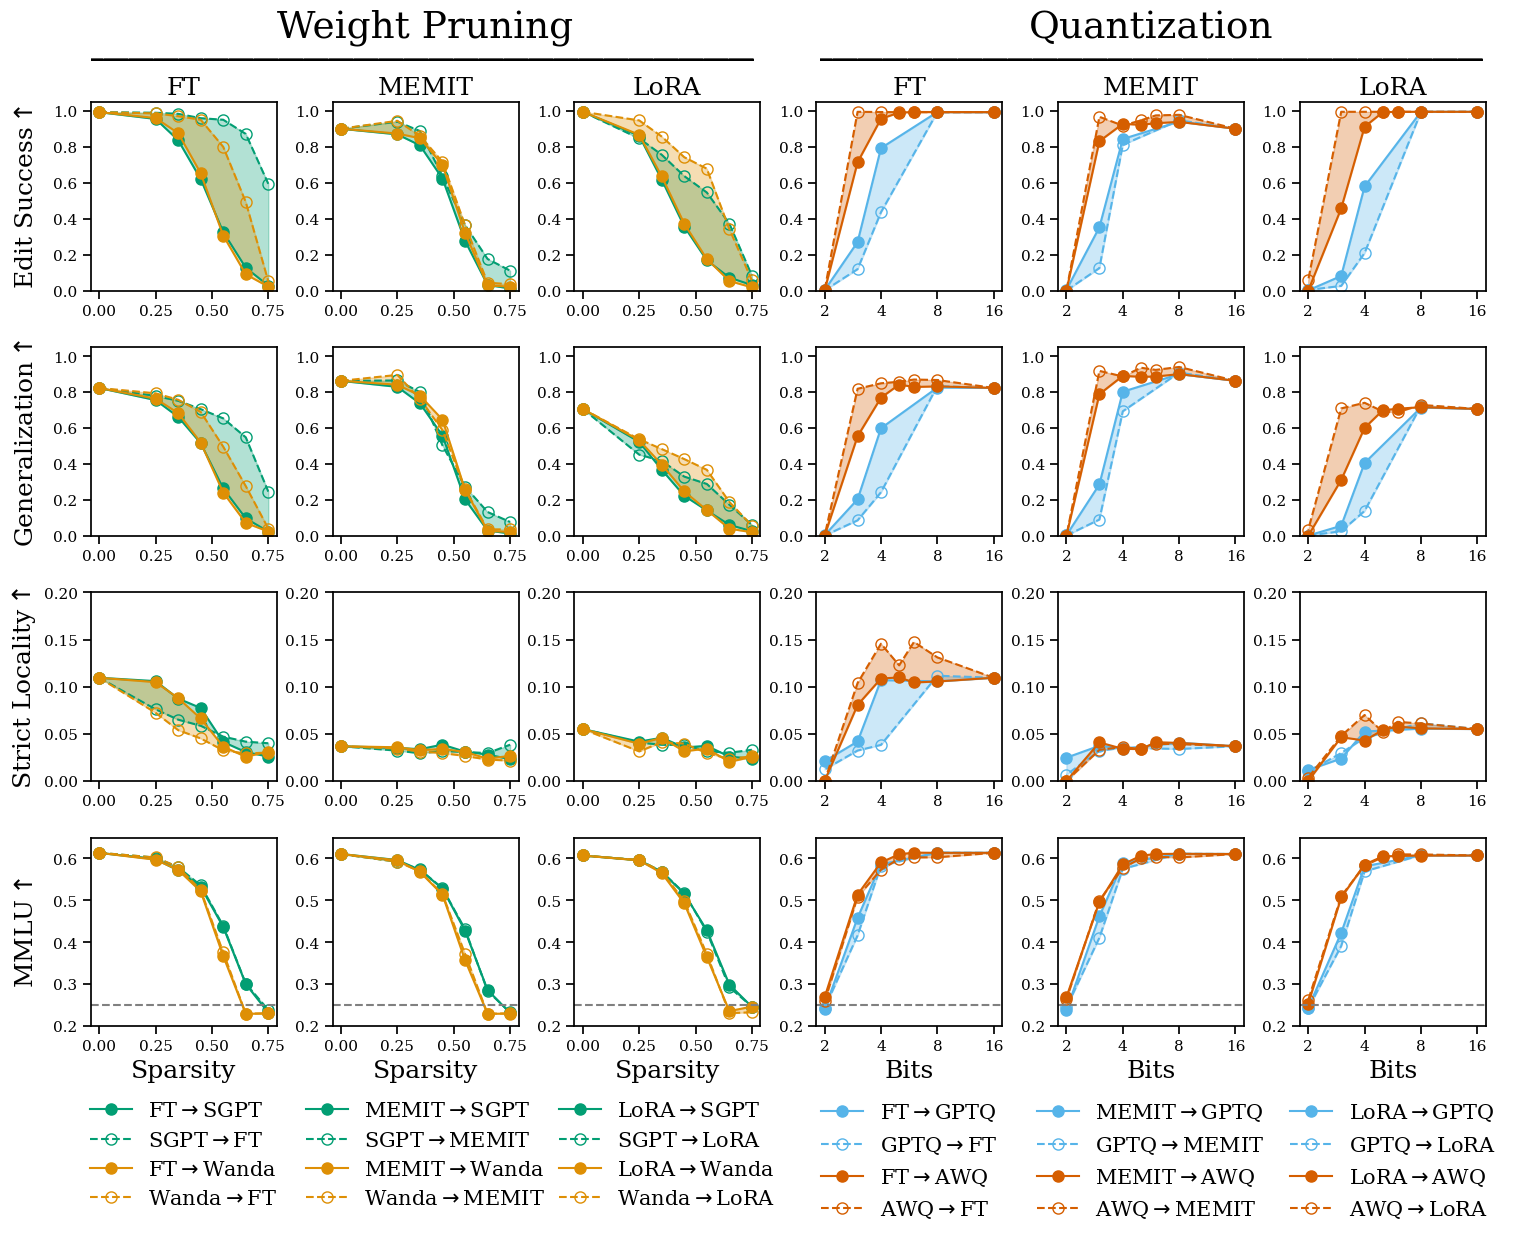

In [40]:
pruning_frame = main_results_plotting_data[((main_results_plotting_data["compression"] == "SparseGPT") | (main_results_plotting_data["compression"] == "Wanda")) & (main_results_plotting_data["edit"] != None) & (main_results_plotting_data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")

quantization_frame = main_results_plotting_data[((main_results_plotting_data["compression"] == "GPTQ") | (main_results_plotting_data["compression"] == "AWQ")) & (main_results_plotting_data["edit"] != None) & (main_results_plotting_data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")

row_metrics = {
    0: "Rewrite accuracy",
    1: "Generalization",
    2: "Locality",
    3: "mmlu accuracy",
}
row_labels = {
    0: r"Edit Success$ \uparrow$",
    1: r"Generalization$ \uparrow$",
    2: r"Strict Locality$ \uparrow$",
    3: r"MMLU$ \uparrow$"
}
column_edit_methods = {
    0: "FT",
    1: "MEMIT",
    2: "LoRA",
    3: "FT",
    4: "MEMIT",
    5: "LoRA",
}
compositions_by_col = {
    0: [("FT→SparseGPT", "SparseGPT→FT"), ("FT→Wanda", "Wanda→FT")],
    1: [("MEMIT→SparseGPT", "SparseGPT→MEMIT"), ("MEMIT→Wanda", "Wanda→MEMIT")],
    2: [("LoRA→SparseGPT", "SparseGPT→LoRA"), ("LoRA→Wanda", "Wanda→LoRA")],
    3: [("FT→GPTQ", "GPTQ→FT"), ("FT→AWQ", "AWQ→FT")],
    4: [("MEMIT→GPTQ", "GPTQ→MEMIT"), ("MEMIT→AWQ", "AWQ→MEMIT")],
    5: [("LoRA→GPTQ", "GPTQ→LoRA"), ("LoRA→AWQ", "AWQ→LoRA")],
}
final_row_index = len(row_labels) - 1

fig, axes = plt.subplots(len(row_labels), 6, figsize=(6 * FIG_SIZE, len(row_labels) * FIG_SIZE))
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, pruning_frame, quantization_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 3 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["edit"] == column_edit_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["MEMIT", "LoRA", "FT"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            first_label = composition[0].replace("SparseGPT", "SGPT").replace("→", "$\\rightarrow$")
            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=first_label)
            second_label = composition[1].replace("SparseGPT", "SGPT").replace("→", "$\\rightarrow$")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=second_label)
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        if x_metric == "wbits":
            ax.set_xscale("log", base=2)
            ax.set_xticks([2, 4, 8, 16], ["2", "4", "8", "16"])

        if row_index != final_row_index:
            ax.set_ylim(0, 1.05)
        else:
            ax.set_ylim(0.2, 0.65)
            ax.axhline(y=0.25, color="gray", linestyle="--")

        if y_metric == "Locality":
            ax.set_ylim(0, .2)

        if row_index == 0:
            title = column_edit_methods[col_index] if column_edit_methods[col_index] != "FT" else "FT"
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[row_index], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == len(row_labels) - 1:
            ax.set_xlabel("Sparsity" if col_index < 3 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == final_row_index:
            ax.legend(fontsize=LEGEND_FONT_SIZE - 1, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)

        if col_index == 1 and row_index == 1:
            ax.set_title("Weight Pruning", fontsize=TITLE_FONT_SIZE * 1.5, y=2.6)
        
        if col_index == 4  and row_index == 1:
            ax.set_title("Quantization", fontsize=TITLE_FONT_SIZE * 1.5, y=2.6)

        if row_index == final_row_index:
            fig.text(0.125, .92, "_____________________________________________________", ha="left", fontsize=TITLE_FONT_SIZE, fontweight="bold")
            fig.text(0.53, .92, "_____________________________________________________", ha="left", fontsize=TITLE_FONT_SIZE, fontweight="bold")


fig.align_ylabels()
fig.align_xlabels()
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_editors_compression.pdf", bbox_inches="tight")

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/578529672.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


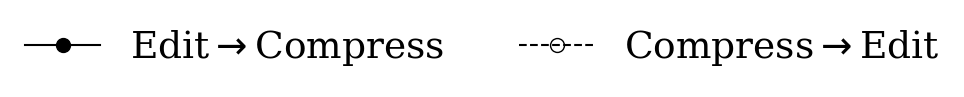

In [41]:

fig, ax = plt.subplots(figsize=(1, 1))  # Adjust size as needed
ax.axis("off")

# Create dummy plots for legend
ax.plot([], [], marker="o", markersize=10, color="black", label=r"Edit$\rightarrow$Compress")
ax.plot([], [], markerfacecolor="none", marker="o", ls="--", markersize=10, color="black", label=r"Compress$\rightarrow$Edit")

# no padidng or margin
legend = ax.legend(fontsize=TITLE_FONT_SIZE * 1.5, frameon=False, loc="center", ncol=2, bbox_to_anchor=(0.5, 0.5))
plt.margins(0)
fig.tight_layout()
plt.close()

fig.savefig("figures/legend_editors_compression.pdf", bbox_inches="tight", pad_inches=0, transparent=True)
fig

## Plot: Unlearning ←→ Compression

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/2960326738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/2960326738.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/2960326738.py:58: SettingWithCopyWarning:

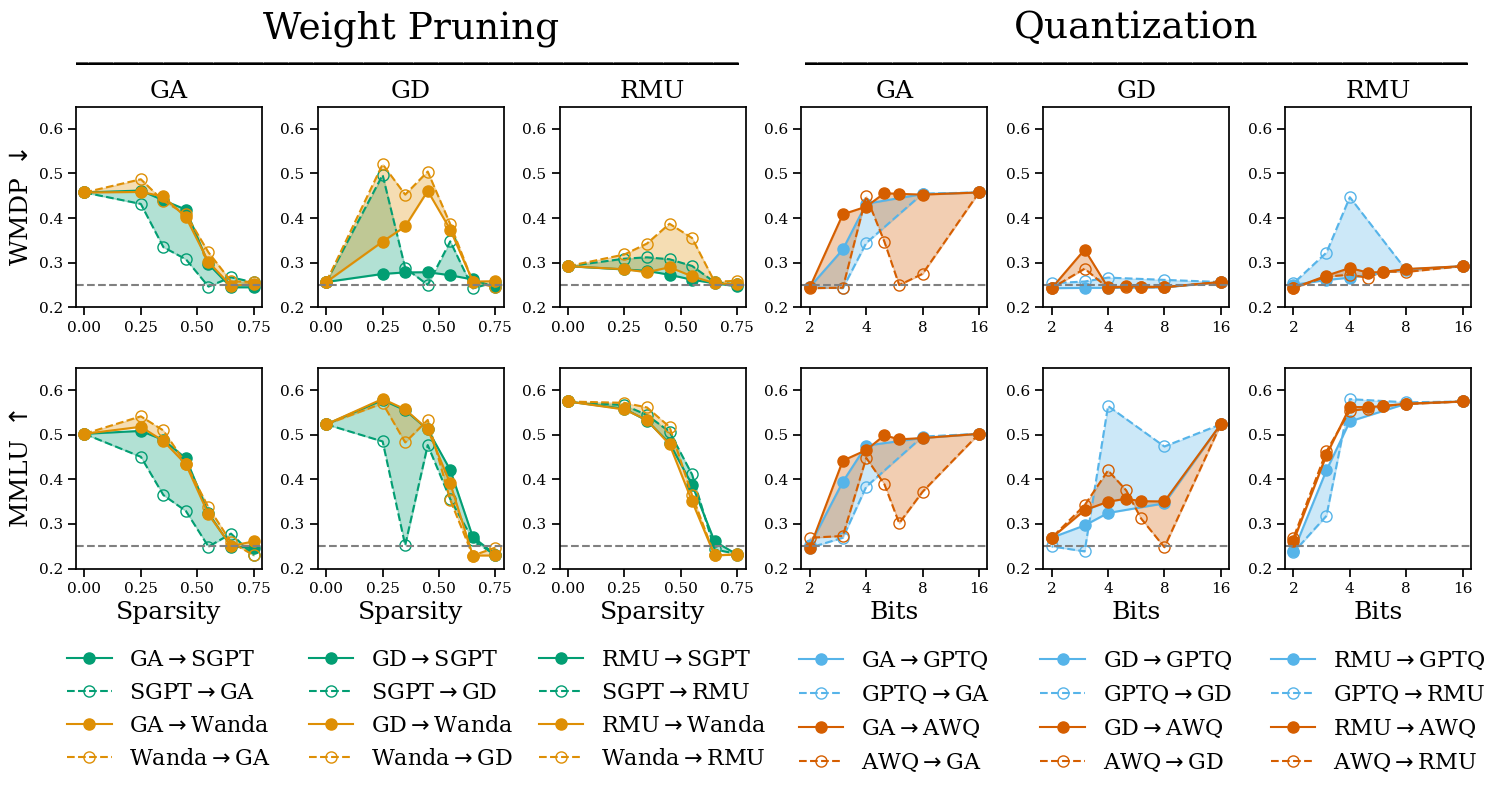

In [42]:
pruning_frame = main_results_plotting_data[((main_results_plotting_data["compression"] == "SparseGPT") | (main_results_plotting_data["compression"] == "Wanda")) & (main_results_plotting_data["unlearn"] != None) & (main_results_plotting_data["interventions"].apply(lambda x: len(x) > 1))]
pruning_frame["order"] = pruning_frame.apply(get_order_label, axis=1)
pruning_frame = pruning_frame.sort_values(by="order")
pruning_frame["unlearn"] = pruning_frame["unlearn"].apply(lambda x: x.upper() if x is not None else None)

quantization_frame = main_results_plotting_data[((main_results_plotting_data["compression"] == "GPTQ") | (main_results_plotting_data["compression"] == "AWQ")) & (main_results_plotting_data["unlearn"] != None) & (main_results_plotting_data["interventions"].apply(lambda x: len(x) > 1))]
quantization_frame["order"] = quantization_frame.apply(get_order_label, axis=1)
quantization_frame = quantization_frame.sort_values(by="order")
quantization_frame["unlearn"] = quantization_frame["unlearn"].apply(lambda x: x.upper() if x is not None else None)

# 4 columns and 3 rows
fig, axes = plt.subplots(2, 6, figsize=(6 * FIG_SIZE, 2 * FIG_SIZE))
row_metrics = {
    0: "Avg WMDP",
    1: "mmlu accuracy",
}
row_labels = {
    "Avg WMDP": r"WMDP $\downarrow$",
    "mmlu accuracy": r"MMLU $\uparrow$"
}
row_label_map = {
    0: "Avg WMDP",
    1: "mmlu accuracy"
}
column_unlearn_methods = {
    0: "GA",
    1: "GD",
    2: "RMU",
    3: "GA",
    4: "GD",
    5: "RMU",
}
final_row_index = len(row_labels) - 1
compositions_by_col = {
    
    # GA and WANDA + SparseGPT
    0: [("GA→SparseGPT", "SparseGPT→GA"), ("GA→Wanda", "Wanda→GA")],
    # FT and WANDA + SparseGPT
    1: [("GD→SparseGPT", "SparseGPT→GD"), ("GD→Wanda", "Wanda→GD")],
    # RMU and WANDA + SparseGPT
    2: [("RMU→SparseGPT", "SparseGPT→RMU"), ("RMU→Wanda", "Wanda→RMU")],
    # GA and GPTQ + AWQ
    3: [("GA→GPTQ", "GPTQ→GA"), ("GA→AWQ", "AWQ→GA")],
    # FT and GPTQ + AWQ
    4: [("GD→GPTQ", "GPTQ→GD"), ("GD→AWQ", "AWQ→GD")],
    # RMU and GPTQ + AWQ
    5: [("RMU→GPTQ", "GPTQ→RMU"), ("RMU→AWQ", "AWQ→RMU")],
}
for row_index, y_metric in row_metrics.items():
    for col_index, plotting_frame in enumerate([pruning_frame, pruning_frame, pruning_frame, quantization_frame, quantization_frame, quantization_frame]):
        ax = axes[row_index][col_index]
        x_metric = "sparsity_ratio" if col_index < 3 else "wbits"
        plotting_frame = plotting_frame[plotting_frame["unlearn"] == column_unlearn_methods[col_index]]

        for composition in compositions_by_col[col_index]:
            compression_method = [method for method in composition[0].split("→") if method not in ["RMU", "GA", "GD"]][0]
            first_line = plotting_frame[plotting_frame["order"] == composition[0]]
            first_line["label"] = first_line["order"].apply(wrap_label)
            second_line = plotting_frame[plotting_frame["order"] == composition[1]].sort_values(x_metric)
            second_line["label"] = second_line["order"].apply(wrap_label)
            if compression_method in ["AWQ", "GPTQ"]:
                first_line = first_line.sort_values(x_metric, ascending=False)
                second_line = second_line.sort_values(x_metric, ascending=False)
            else:
                first_line = first_line.sort_values(x_metric)
                second_line = second_line.sort_values(x_metric)

            first_label = composition[0].replace("SparseGPT", "SGPT").replace("→", "$\\rightarrow$")
            ax.plot(first_line[x_metric], first_line[y_metric], marker="o", markersize=MARKER_SIZE, color=colors[compression_method], label=first_label)
            second_label = composition[1].replace("SparseGPT", "SGPT").replace("→", "$\\rightarrow$")
            ax.plot(second_line[x_metric], second_line[y_metric], markerfacecolor='none', marker="o", ls="--", markersize=MARKER_SIZE, color=colors[compression_method], label=second_label)
            ax.fill_between(
                x=first_line[x_metric], y1=first_line[y_metric], y2=second_line[y_metric],
                alpha=0.3,
                color=colors[compression_method]
            )

        ax.axhline(y=0.25, color="gray", linestyle="--")
        ax.set_ylim(0.20, 0.65)

        if x_metric == "wbits":
            ax.set_xscale("log", base=2)
            ax.set_xticks([2, 4, 8, 16], ["2", "4", "8", "16"])

        if row_index == 0:
            title = column_unlearn_methods[col_index]
            ax.set_title(title, fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_title("")

        if col_index == 0:
            ax.set_ylabel(row_labels[list(row_labels.keys())[row_index]], fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_ylabel("")

        if row_index == 1:
            ax.set_xlabel("Sparsity" if col_index < 3 else "Bits", fontsize=TITLE_FONT_SIZE)
        else:
            ax.set_xlabel("")

        if row_index == 1:
            ax.legend(fontsize=LEGEND_FONT_SIZE, frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=1)
        
        if col_index == 1 and row_index == 1:
            ax.set_title("Weight Pruning", fontsize=TITLE_FONT_SIZE * 1.5, y=2.6)
            
        if col_index == 4  and row_index == 1:
            ax.set_title("Quantization", fontsize=TITLE_FONT_SIZE * 1.5, y=2.6)

        if row_index == final_row_index:
            fig.text(0.125, 0.96, "_____________________________________________________", ha="left", fontsize=TITLE_FONT_SIZE, fontweight="bold")
            fig.text(0.53, 0.96, "_____________________________________________________", ha="left", fontsize=TITLE_FONT_SIZE, fontweight="bold")

fig.align_ylabels()
fig.align_xlabels()
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
plt.savefig("figures/main_results_unlearn_compression.pdf", bbox_inches="tight")

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/143542695.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


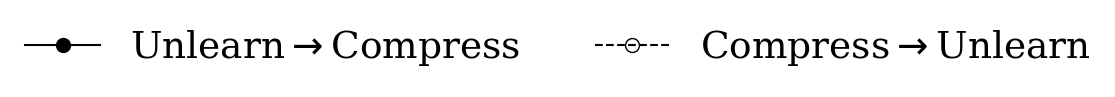

In [43]:

fig, ax = plt.subplots(figsize=(1, 1))  # Adjust size as needed
ax.axis("off")

# Create dummy plots for legend
ax.plot([], [], marker="o", markersize=10, color="black", label=r"Unlearn$\rightarrow$Compress")
ax.plot([], [], markerfacecolor="none", marker="o", ls="--", markersize=10, color="black", label=r"Compress$\rightarrow$Unlearn")

# no padidng or margin
legend = ax.legend(fontsize=TITLE_FONT_SIZE * 1.5, frameon=False, loc="center", ncol=2, bbox_to_anchor=(0.5, 0.5))
plt.margins(0)
fig.tight_layout()
plt.close()

fig.savefig("figures/legend_unlearn_compression.pdf", bbox_inches="tight", pad_inches=0, transparent=True)
fig

# Ablation Results

In [67]:
all_runs_df_deduplicated.value_counts("model_name")

model_name
Llama-3 (8b)    311
Phi-3 (3.8b)    123
Mistral (7b)     78
Yi 1.5 (9b)      37
Name: count, dtype: int64

In [116]:
def get_ablation_metrics_frames(model_results_frame):
    intervention_names = [intervention for intervention in list(model_results_frame["edit"].unique()) + list(model_results_frame["unlearn"].unique()) + list(model_results_frame["compression"].unique()) if intervention is not None]
    intervention_type = {
        "MEMIT": "edit",
        "Wanda": "compression",
        "AWQ": "compression",
        "RMU": "unlearn",
    }

    # Initialize heatmap data frames with default values
    default_value = None
    mmlu_oi_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
    wmdp_oi_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
    edit_oi_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
    generalization_oi_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
    locality_oi_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

    # Initialize max value data frames
    mmlu_mce_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
    wmdp_mce_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
    edit_mce_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
    generalization_mce_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)
    locality_mce_model_results_frame = pd.DataFrame(index=intervention_names, columns=intervention_names, dtype=float, data=default_value)

    # Populate the heatmap and max value data frames
    for first_intervention in intervention_names:
        for second_intervention in intervention_names:
            first_intervention_type = intervention_type.get(first_intervention, None)
            second_intervention_type = intervention_type.get(second_intervention, None)
            if first_intervention_type == second_intervention_type:
                continue
            elif first_intervention_type is None or second_intervention_type is None:
                continue

            compositions = model_results_frame[(model_results_frame[first_intervention_type] == first_intervention) & (model_results_frame[second_intervention_type] == second_intervention)]
            if first_intervention in ["Wanda"] or second_intervention in ["SparseGPT", "Wanda"]:
                compositions = compositions[compositions["sparsity_ratio"] == 0.25]
            elif first_intervention in ["AWQ"] or second_intervention in ["GPTQ", "AWQ"]:
                compositions = compositions[compositions["wbits"] == 4]
            
            assert len(compositions) == 2, f"Expected 2 compositions for {first_intervention} and {second_intervention}, but found {len(compositions)}"
            
            # Calculate OIs
            mmlu_diff = abs(compositions["mmlu accuracy"].iloc[0] - compositions["mmlu accuracy"].iloc[1]).round(4)
            mmlu_oi_model_results_frame[first_intervention][second_intervention] = mmlu_diff
            
            avg_wmdp_diff = abs(((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2) - ((compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2)).round(4)
            wmdp_oi_model_results_frame[first_intervention][second_intervention] = avg_wmdp_diff
            
            edit_diff = abs(compositions["Rewrite accuracy"].iloc[0] - compositions["Rewrite accuracy"].iloc[1]).round(4)
            edit_oi_model_results_frame[first_intervention][second_intervention] = edit_diff

            generalization_diff = abs(compositions["Generalization"].iloc[0] - compositions["Generalization"].iloc[1]).round(4)
            generalization_oi_model_results_frame[first_intervention][second_intervention] = generalization_diff

            locality_diff = abs(compositions["Locality"].iloc[0] - compositions["Locality"].iloc[1]).round(4)
            locality_oi_model_results_frame[first_intervention][second_intervention] = locality_diff
            
            # Calculate MCE values
            mmlu_mce = 1 - max(compositions["mmlu accuracy"].iloc[0], compositions["mmlu accuracy"].iloc[1]).round(4)
            mmlu_mce_model_results_frame[first_intervention][second_intervention] = mmlu_mce
            
            avg_wmdp_acc = min((compositions.iloc[0]["wmdp_cyber accuracy"] + compositions.iloc[0]["wmdp_bio accuracy"]) / 2, (compositions.iloc[1]["wmdp_cyber accuracy"] + compositions.iloc[1]["wmdp_bio accuracy"]) / 2).round(4)
            wmdp_mce_model_results_frame[first_intervention][second_intervention] = avg_wmdp_acc
            
            edit_mce = 1 - max(compositions["Rewrite accuracy"].iloc[0], compositions["Rewrite accuracy"].iloc[1]).round(4)
            edit_mce_model_results_frame[first_intervention][second_intervention] = edit_mce

            generalization_mce = 1 - max(compositions["Generalization"].iloc[0], compositions["Generalization"].iloc[1]).round(4)
            generalization_mce_model_results_frame[first_intervention][second_intervention] = generalization_mce

            locality_mce = 1 - max(compositions["Locality"].iloc[0], compositions["Locality"].iloc[1]).round(4)
            locality_mce_model_results_frame[first_intervention][second_intervention] = locality_mce

    model_name = model_results_frame["model_name"].iloc[0]

    # Display the results
    display(f"MMLU OI: {model_name}")
    display(mmlu_oi_model_results_frame)

    display(f"MMLU MCE Values: {model_name}")
    display(mmlu_mce_model_results_frame)

    display(f"WMDP OI: {model_name}")
    display(wmdp_oi_model_results_frame)

    display(f"WMDP MCE Values: {model_name}")
    display(wmdp_mce_model_results_frame)

    display(f"Rewrite OI: {model_name}")
    display(edit_oi_model_results_frame)

    display(f"Rewrite MCE Values: {model_name}")
    display(edit_mce_model_results_frame)

    display(f"Generalization OI: {model_name}")
    display(generalization_oi_model_results_frame)

    display(f"Generalization MCE Values: {model_name}")
    display(generalization_mce_model_results_frame)

    display(f"Locality OI: {model_name}")
    display(locality_oi_model_results_frame)

    display(f"Locality MCE Values: {model_name}")
    display(locality_mce_model_results_frame)

    return {
        "MMLU OI": mmlu_oi_model_results_frame,
        "MMLU MCE": mmlu_mce_model_results_frame,
        "WMDP OI": wmdp_oi_model_results_frame,
        "WMDP MCE": wmdp_mce_model_results_frame,
        "Edit Success OI": edit_oi_model_results_frame,
        "Edit MCE": edit_mce_model_results_frame,
        "Edit Generalization OI": generalization_oi_model_results_frame,
        "Edit Generalization MCE": generalization_mce_model_results_frame,
        "Edit Locality OI": locality_oi_model_results_frame,
        "Edit Locality MCE": locality_mce_model_results_frame,
    }


model_results = {}
ablation_models = ["Mistral (7b)", "Yi 1.5 (9b)", "Llama-3 (8b)"]
for model in ablation_models:
    model_frame = all_runs_df_deduplicated[all_runs_df_deduplicated["model_name"] == model]
    model_results[model] = get_ablation_metrics_frames(model_frame)

model_results

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/1984266841.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mmlu_oi_model_results_frame[first_intervention][second_intervention] = mmlu_diff
/var/folders/_m/m_v8tmqs05lf3_0

'MMLU OI: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.0125,NaN,0.0120,0.0115
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.0125,NaN,NaN,NaN,NaN,0.0014,0.0007
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.0120,NaN,NaN,0.0014,NaN,NaN,NaN
Wanda,0.0115,NaN,NaN,0.0007,NaN,NaN,NaN


'MMLU MCE Values: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.4268,NaN,0.4303,0.4294
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.4268,NaN,NaN,NaN,NaN,0.4242,0.4209
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.4303,NaN,NaN,0.4242,NaN,NaN,NaN
Wanda,0.4294,NaN,NaN,0.4209,NaN,NaN,NaN


'WMDP OI: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.0000,NaN,0.0114,0.0069
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.0000,NaN,NaN,NaN,NaN,0.0384,0.0023
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.0114,NaN,NaN,0.0384,NaN,NaN,NaN
Wanda,0.0069,NaN,NaN,0.0023,NaN,NaN,NaN


'WMDP MCE Values: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.2791,NaN,0.5146,0.5242
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.2791,NaN,NaN,NaN,NaN,0.2697,0.2780
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.5146,NaN,NaN,0.2697,NaN,NaN,NaN
Wanda,0.5242,NaN,NaN,0.2780,NaN,NaN,NaN


'Rewrite OI: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.03,NaN,0.1071,0.0005
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.0300,NaN,NaN,NaN,NaN,0.0000,0.0000
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.1071,NaN,NaN,0.00,NaN,NaN,NaN
Wanda,0.0005,NaN,NaN,0.00,NaN,NaN,NaN


'Rewrite MCE Values: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.0200,NaN,0.1444,0.2493
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.0200,NaN,NaN,NaN,NaN,0.9887,0.9887
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.1444,NaN,NaN,0.9887,NaN,NaN,NaN
Wanda,0.2493,NaN,NaN,0.9887,NaN,NaN,NaN


'Generalization OI: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.0155,NaN,0.0432,0.0177
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.0155,NaN,NaN,NaN,NaN,0.0044,0.0000
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.0432,NaN,NaN,0.0044,NaN,NaN,NaN
Wanda,0.0177,NaN,NaN,0.0000,NaN,NaN,NaN


'Generalization MCE Values: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.1589,NaN,0.2979,0.3365
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.1589,NaN,NaN,NaN,NaN,0.9804,0.9848
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.2979,NaN,NaN,0.9804,NaN,NaN,NaN
Wanda,0.3365,NaN,NaN,0.9848,NaN,NaN,NaN


'Locality OI: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.0138,NaN,0.0357,0.0414
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.0138,NaN,NaN,NaN,NaN,0.0113,0.0133
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.0357,NaN,NaN,0.0113,NaN,NaN,NaN
Wanda,0.0414,NaN,NaN,0.0133,NaN,NaN,NaN


'Locality MCE Values: Mistral (7b)'

,MEMIT,Fine-tune,LoRA,RMU,GD,AWQ,Wanda
MEMIT,NaN,NaN,NaN,0.9206,NaN,0.8653,0.9058
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,0.9206,NaN,NaN,NaN,NaN,0.9567,0.9473
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWQ,0.8653,NaN,NaN,0.9567,NaN,NaN,NaN
Wanda,0.9058,NaN,NaN,0.9473,NaN,NaN,NaN


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/1984266841.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mmlu_oi_model_results_frame[first_intervention][second_intervention] = mmlu_diff
/var/folders/_m/m_v8tmqs05lf3_0

'MMLU OI: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.0119,0.0039
AWQ,0.0119,NaN,NaN
Wanda,0.0039,NaN,NaN


'MMLU MCE Values: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.326,0.325
AWQ,0.326,NaN,NaN
Wanda,0.325,NaN,NaN


'WMDP OI: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.0063,0.0062
AWQ,0.0063,NaN,NaN
Wanda,0.0062,NaN,NaN


'WMDP MCE Values: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.5508,0.5578
AWQ,0.5508,NaN,NaN
Wanda,0.5578,NaN,NaN


'Rewrite OI: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.0063,0.0146
AWQ,0.0063,NaN,NaN
Wanda,0.0146,NaN,NaN


'Rewrite MCE Values: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.969,0.9707
AWQ,0.9690,NaN,NaN
Wanda,0.9707,NaN,NaN


'Generalization OI: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.0085,0.0094
AWQ,0.0085,NaN,NaN
Wanda,0.0094,NaN,NaN


'Generalization MCE Values: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.9733,0.9797
AWQ,0.9733,NaN,NaN
Wanda,0.9797,NaN,NaN


'Locality OI: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.0008,0.0049
AWQ,0.0008,NaN,NaN
Wanda,0.0049,NaN,NaN


'Locality MCE Values: Yi 1.5 (9b)'

,MEMIT,AWQ,Wanda
MEMIT,NaN,0.9708,0.9669
AWQ,0.9708,NaN,NaN
Wanda,0.9669,NaN,NaN


/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_58298/1984266841.py:45: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mmlu_oi_model_results_frame[first_intervention][second_intervention] = mmlu_diff
/var/folders/_m/m_v8tmqs05lf3_0

'MMLU OI: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.0025,0.0084,NaN,NaN,0.0034
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.0025,NaN,NaN,NaN,0.0085,NaN,NaN,0.0148
AWQ,NaN,NaN,0.0084,NaN,NaN,0.0085,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.0034,NaN,NaN,0.0148,NaN,NaN,NaN,NaN


'MMLU MCE Values: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.4381,0.4142,NaN,NaN,0.4044
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.4381,NaN,NaN,NaN,0.4383,NaN,NaN,0.4288
AWQ,NaN,NaN,0.4142,NaN,NaN,0.4383,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.4044,NaN,NaN,0.4288,NaN,NaN,NaN,NaN


'WMDP OI: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.0086,0.0023,NaN,NaN,0.0014
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.0086,NaN,NaN,NaN,0.0150,NaN,NaN,0.0332
AWQ,NaN,NaN,0.0023,NaN,NaN,0.0150,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.0014,NaN,NaN,0.0332,NaN,NaN,NaN,NaN


'WMDP MCE Values: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.2928,0.5516,NaN,NaN,0.5573
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.2928,NaN,NaN,NaN,0.2733,NaN,NaN,0.2854
AWQ,NaN,NaN,0.5516,NaN,NaN,0.2733,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.5573,NaN,NaN,0.2854,NaN,NaN,NaN,NaN


'Rewrite OI: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.0125,0.0099,NaN,NaN,0.0711
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.0125,NaN,NaN,NaN,0.0059,NaN,NaN,0.0005
AWQ,NaN,NaN,0.0099,NaN,NaN,0.0059,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.0711,NaN,NaN,0.0005,NaN,NaN,NaN,NaN


'Rewrite MCE Values: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.0313,0.0710,NaN,NaN,0.0541
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.0313,NaN,NaN,NaN,0.9759,NaN,NaN,0.9804
AWQ,NaN,NaN,0.0710,NaN,NaN,0.9759,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.0541,NaN,NaN,0.9804,NaN,NaN,NaN,NaN


'Generalization OI: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.0359,0.0033,NaN,NaN,0.0549
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.0359,NaN,NaN,NaN,0.0027,NaN,NaN,0.0057
AWQ,NaN,NaN,0.0033,NaN,NaN,0.0027,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.0549,NaN,NaN,0.0057,NaN,NaN,NaN,NaN


'Generalization MCE Values: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.0703,0.1095,NaN,NaN,0.1039
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.0703,NaN,NaN,NaN,0.9772,NaN,NaN,0.9765
AWQ,NaN,NaN,0.1095,NaN,NaN,0.9772,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.1039,NaN,NaN,0.9765,NaN,NaN,NaN,NaN


'Locality OI: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.0008,0.0020,NaN,NaN,0.0014
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.0008,NaN,NaN,NaN,0.0032,NaN,NaN,0.0005
AWQ,NaN,NaN,0.0020,NaN,NaN,0.0032,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.0014,NaN,NaN,0.0005,NaN,NaN,NaN,NaN


'Locality MCE Values: Llama-3 (8b)'

,Fine-tune,LoRA,MEMIT,GA,GD,RMU,AWQ,GPTQ,SparseGPT,Wanda
Fine-tune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMIT,NaN,NaN,NaN,NaN,NaN,0.9652,0.9639,NaN,NaN,0.9643
GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RMU,NaN,NaN,0.9652,NaN,NaN,NaN,0.9658,NaN,NaN,0.9623
AWQ,NaN,NaN,0.9639,NaN,NaN,0.9658,NaN,NaN,NaN,NaN
GPTQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SparseGPT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wanda,NaN,NaN,0.9643,NaN,NaN,0.9623,NaN,NaN,NaN,NaN


{'Mistral (7b)': {'MMLU OI':             MEMIT  Fine-tune  LoRA     RMU  GD     AWQ   Wanda
  MEMIT         NaN        NaN   NaN  0.0125 NaN  0.0120  0.0115
  Fine-tune     NaN        NaN   NaN     NaN NaN     NaN     NaN
  LoRA          NaN        NaN   NaN     NaN NaN     NaN     NaN
  RMU        0.0125        NaN   NaN     NaN NaN  0.0014  0.0007
  GD            NaN        NaN   NaN     NaN NaN     NaN     NaN
  AWQ        0.0120        NaN   NaN  0.0014 NaN     NaN     NaN
  Wanda      0.0115        NaN   NaN  0.0007 NaN     NaN     NaN,
  'MMLU MCE':             MEMIT  Fine-tune  LoRA     RMU  GD     AWQ   Wanda
  MEMIT         NaN        NaN   NaN  0.4268 NaN  0.4303  0.4294
  Fine-tune     NaN        NaN   NaN     NaN NaN     NaN     NaN
  LoRA          NaN        NaN   NaN     NaN NaN     NaN     NaN
  RMU        0.4268        NaN   NaN     NaN NaN  0.4242  0.4209
  GD            NaN        NaN   NaN     NaN NaN     NaN     NaN
  AWQ        0.4303        NaN   NaN  0.4242 NaN  

In [120]:
def format_hundredths(number):
    rounded = round(number, 2)
    return f"{rounded:.2f}".lstrip("0")


latex_code = r"""
\begin{tabular}{lcccccccccccc}
    \toprule
    & \multicolumn{3}{c}{\textbf{Edit Success}} & \multicolumn{3}{c}{\textbf{Generalization}} & \multicolumn{3}{c}{\textbf{WMDP}} & \multicolumn{3}{c}{\textbf{MMLU}} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
    \textbf{Composition} & \textbf{Mistral} & \textbf{Yi} & \textbf{Llama} & \textbf{Mistral} & \textbf{Yi} & \textbf{Llama} & \textbf{Mistral} & \textbf{Yi} & \textbf{Llama} & \textbf{Mistral} & \textbf{Yi} & \textbf{Llama} \\
    \midrule
"""

for composition in [("MEMIT", "Wanda"), ("MEMIT", "AWQ"), ("MEMIT", "RMU"), ("RMU", "AWQ"), ("RMU", "Wanda")]:
    row_entries = []
    composition_label = composition[0] + r"$\leftrightarrow$" + composition[1]
    row_entries.append(composition_label)
    for metric in ["Edit Success", "Edit Generalization", "WMDP", "MMLU"]:
        for model in ablation_models:
            table_entry = "-"
            try:
                table_entry = model_results[model][metric + " OI"].loc[composition[0], composition[1]].round(2)
                table_entry = format_hundredths(table_entry)
            except KeyError:
                pass
            
            row_entries.append(table_entry)

    latex_code += "    "+ " & ".join(row_entries) + r" \\" + "\n"

latex_code += r'''    \bottomrule \\
\end{tabular}
'''

print(latex_code)




\begin{tabular}{lcccccccccccc}
    \toprule
    & \multicolumn{3}{c}{\textbf{Edit Success}} & \multicolumn{3}{c}{\textbf{Generalization}} & \multicolumn{3}{c}{\textbf{WMDP}} & \multicolumn{3}{c}{\textbf{MMLU}} \\
    \cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10} \cmidrule(lr){11-13}
    \textbf{Composition} & \textbf{Mistral} & \textbf{Yi} & \textbf{Llama} & \textbf{Mistral} & \textbf{Yi} & \textbf{Llama} & \textbf{Mistral} & \textbf{Yi} & \textbf{Llama} & \textbf{Mistral} & \textbf{Yi} & \textbf{Llama} \\
    \midrule
    MEMIT$\leftrightarrow$Wanda & .00 & .01 & .07 & .02 & .01 & .05 & .01 & .01 & .00 & .01 & .00 & .00 \\
    MEMIT$\leftrightarrow$AWQ & .11 & .01 & .01 & .04 & .01 & .00 & .01 & .01 & .00 & .01 & .01 & .01 \\
    MEMIT$\leftrightarrow$RMU & .03 & - & .01 & .02 & - & .04 & .00 & - & .01 & .01 & - & .00 \\
    RMU$\leftrightarrow$AWQ & .00 & - & .01 & .00 & - & .00 & .04 & - & .02 & .00 & - & .01 \\
    RMU$\leftrightarrow$Wanda & .00 & - & .00 & .00 & - & 